In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
# Modeling 
library(effsize);
})

In [112]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Language Switching A/B Test Analysis

**Jennifer Wang, Staff Data Scientist, Wikimedia Foundation**

**28 Septembter 2021**

[TICKET](https://phabricator.wikimedia.org/T285755)

# Table of Contents
1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
3. [Methodology](#Methodology)
4. [Language Link Clicks](#Language-Link-Clicks)
5. [Input Language Link Clicks](#Input-Language-Link-Clicks)
6. [Interface Language Link Clicks](#Interface-Language-Link-Clicks)
7. [Other Interesting Trends](#Other-Interesting-Trends)

# Introduction
As a part of the [Desktop Improvements project](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements), The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team)  is introducing a new way to switch to a different language wiki. The original language list appears on the sidebar. The new solution replaces the original one by providing 1) a language option button on the top of the page, 2) Selecting the language button will open the list of languages that will contain the suggested languages for each user, as well as a full list of all available languages for that article.
You can find more information on this change and other feature deployments on the [Language switching project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/Language_switching).


For the logged-in users, an AB test was performed on the early adopter wikis except fawiki between June 22, 2021 and July 20, 2021. On fawiki, the AB test was performed between June 28 and July 20, 2021. This report details the analysis and results for the language switch AB test.

For the logged-out users, [another report](https://github.com/jenniferwang-wmf/Web_language_switch/blob/master/Language_switching_logout_user_before_after_report.ipynb) details the analysis and results for the deployment of language switch on logged-out users. 

# Purpose

The primary goal of the AB Test was to test the hypothesis that the group with the new language button and links will get more clicks as it is to discover.

As part of this analysis, we were also interested in identifying any interesting trends in user behavior.


# Methodology

The AB test was run on a per wiki basis on logged-in users. Users included in the test were randomly assigned to either the control (old language switch) or treatment (new language switch) based on their user ID. 

We compared the total numbers of clicks between control and treatment groups. There are three use scenarios: clicks on language links, clicks on input language links, and clicks on interface language links. We reviewed each use scenario separately.
  
We also reviewed the difference in percentage between the treatment group and the control group. Ran one-sample t-test to determine if the difference is statistically significant.


# Language Link Clicks

__New feature -- language link clicks after new button clicks__
<img src="Figures/new_lang_link.png" width="800" height="600" align="center"/>

In [4]:
query_language_clicks_new <- 
"
-- sessions where new lang button was selected
WITH new_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon = false
    AND event.action = 'compact-language-links-open'
    AND event.context = 'header'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    event.isanon,
    wiki
),

lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon = false
    AND event.action = 'language-change'
    AND event.context='content-language-switcher'
    AND event.skinVersion = 'latest'
)

SELECT
    new_button.button_date,
    lang_switches.switch_date,
    new_button.session_id,
    new_button.wiki,
    new_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    lang_switches.switch_context
FROM new_button
LEFT JOIN lang_switches ON
    new_button.session_id = lang_switches.session_id AND
    new_button.wiki = lang_switches.wiki 
"

In [113]:
#new_language_link_clicks <-  wmfdata::query_hive(query_language_clicks_new)

In [7]:
#write_csv(new_language_link_clicks, file = 'Data_login/new_language_link_clicks.csv')

In [8]:
#new_language_link_clicks <- read_csv('Data_login/new_language_link_clicks.csv')

In [9]:
new_lang_link_clicks_by_date <- new_language_link_clicks  %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(n_events_new_language_change = n(), .groups = 'drop')

new_lang_link_clicks_by_date$switch_date <- as.Date(new_lang_link_clicks_by_date$switch_date)

__Old feature -- language link clicks on sidebar__

<img src="Figures/old_lang_link.png" width="200" height="120" align="center"/>

In [11]:
query_old_language_link <- 
"
SELECT
    TO_DATE(dt) AS `date`,
    wiki,
    event.web_session_id,
    event.usereditbucket,
    event.timetochangelanguage,
    event.interfacelanguage,
    event.contentlanguage,
    event.selectedinterfacelanguage,
    Count(*) AS n_events
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND event.context = 'languages-list' and event.action = 'language-change' 
    AND event.skinVersion = 'latest' 
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
GROUP BY
    TO_DATE(dt),
    wiki,
    event.web_session_id,
    event.usereditbucket,
    event.timetochangelanguage,
    event.interfacelanguage,
    event.contentlanguage,
    event.selectedinterfacelanguage
"

In [114]:
#old_lang_link_clicks <-  wmfdata::query_hive(query_old_language_link)

In [13]:
#write_csv(old_lang_link_clicks, file = 'Data_login/old_lang_link_clicks.csv')

In [14]:
#old_lang_link_clicks <- read_csv('Data_login/old_lang_link_clicks.csv')

In [15]:
old_lang_link_clicks_by_date <- old_lang_link_clicks %>%
    group_by( wiki, date) %>%
    summarize(n_events_language_link = sum(n_events),.groups='drop')

In [17]:
old_lang_link_clicks_by_date$date <- as.Date(old_lang_link_clicks_by_date$date)

__Old feature -- language link clicks after N-more button clicks on sidebar__
<img src="Figures/old_N-more.png" width="400" height="200" align="center"/>

In [18]:
query_n_more_lang_switch <- 
"
-- sessions where N-more lang button was selected
WITH button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'compact-language-links-open'
    AND event.context = 'other'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    wiki
),

lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.isanon,
    event.context as switch_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'language-change'
    AND event.context='content-language-switcher'
    AND event.skinVersion = 'latest'
)

SELECT
    button.button_date,
    lang_switches.switch_date,
    button.session_id,
    button.wiki,
    button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(lang_switches.session_id IS NOT NULL AND switch_date >= button_date , 1, 0) AS language_switch,
    lang_switches.switch_context
FROM button
LEFT JOIN lang_switches ON
    button.session_id = lang_switches.session_id AND
    button.wiki = lang_switches.wiki
"

In [115]:
#n_more_lang_clicks <-  wmfdata::query_hive(query_n_more_lang_switch)

In [20]:
#write_csv(n_more_lang_clicks, file = 'Data_login/n_more_switch_lang_clicks.csv')

In [21]:
#n_more_lang_clicks <- read_csv('Data_login/n_more_switch_lang_clicks.csv')

In [23]:
n_more_lang_clicks_by_date <- n_more_lang_clicks %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(n_events_n_more_language_switch = sum(language_switch),.groups='drop')

n_more_lang_clicks_by_date$switch_date <- as.Date(n_more_lang_clicks_by_date$switch_date)

In [25]:
date_seq <- seq(as.Date('2021-06-22'), as.Date('2021-07-20'), by = 'days')

In [26]:
wiki_seq <- c('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')

In [27]:
df_lang_clicks= expand.grid(date=date_seq, wiki=wiki_seq )

In [28]:
df_lang_clicks<-  merge(df_lang_clicks , new_lang_link_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)
df_lang_clicks <-  merge(df_lang_clicks , old_lang_link_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","date"), all.x = TRUE)
df_lang_clicks <-  merge(df_lang_clicks , n_more_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"),  all.x = TRUE)

In [29]:
df_lang_clicks[is.na(df_lang_clicks)] <- 0

In [31]:
df_lang_clicks <- mutate(df_lang_clicks, n_events_control=n_events_language_link+n_events_n_more_language_switch)

In [32]:
df_lang_clicks <- df_lang_clicks %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'),
)

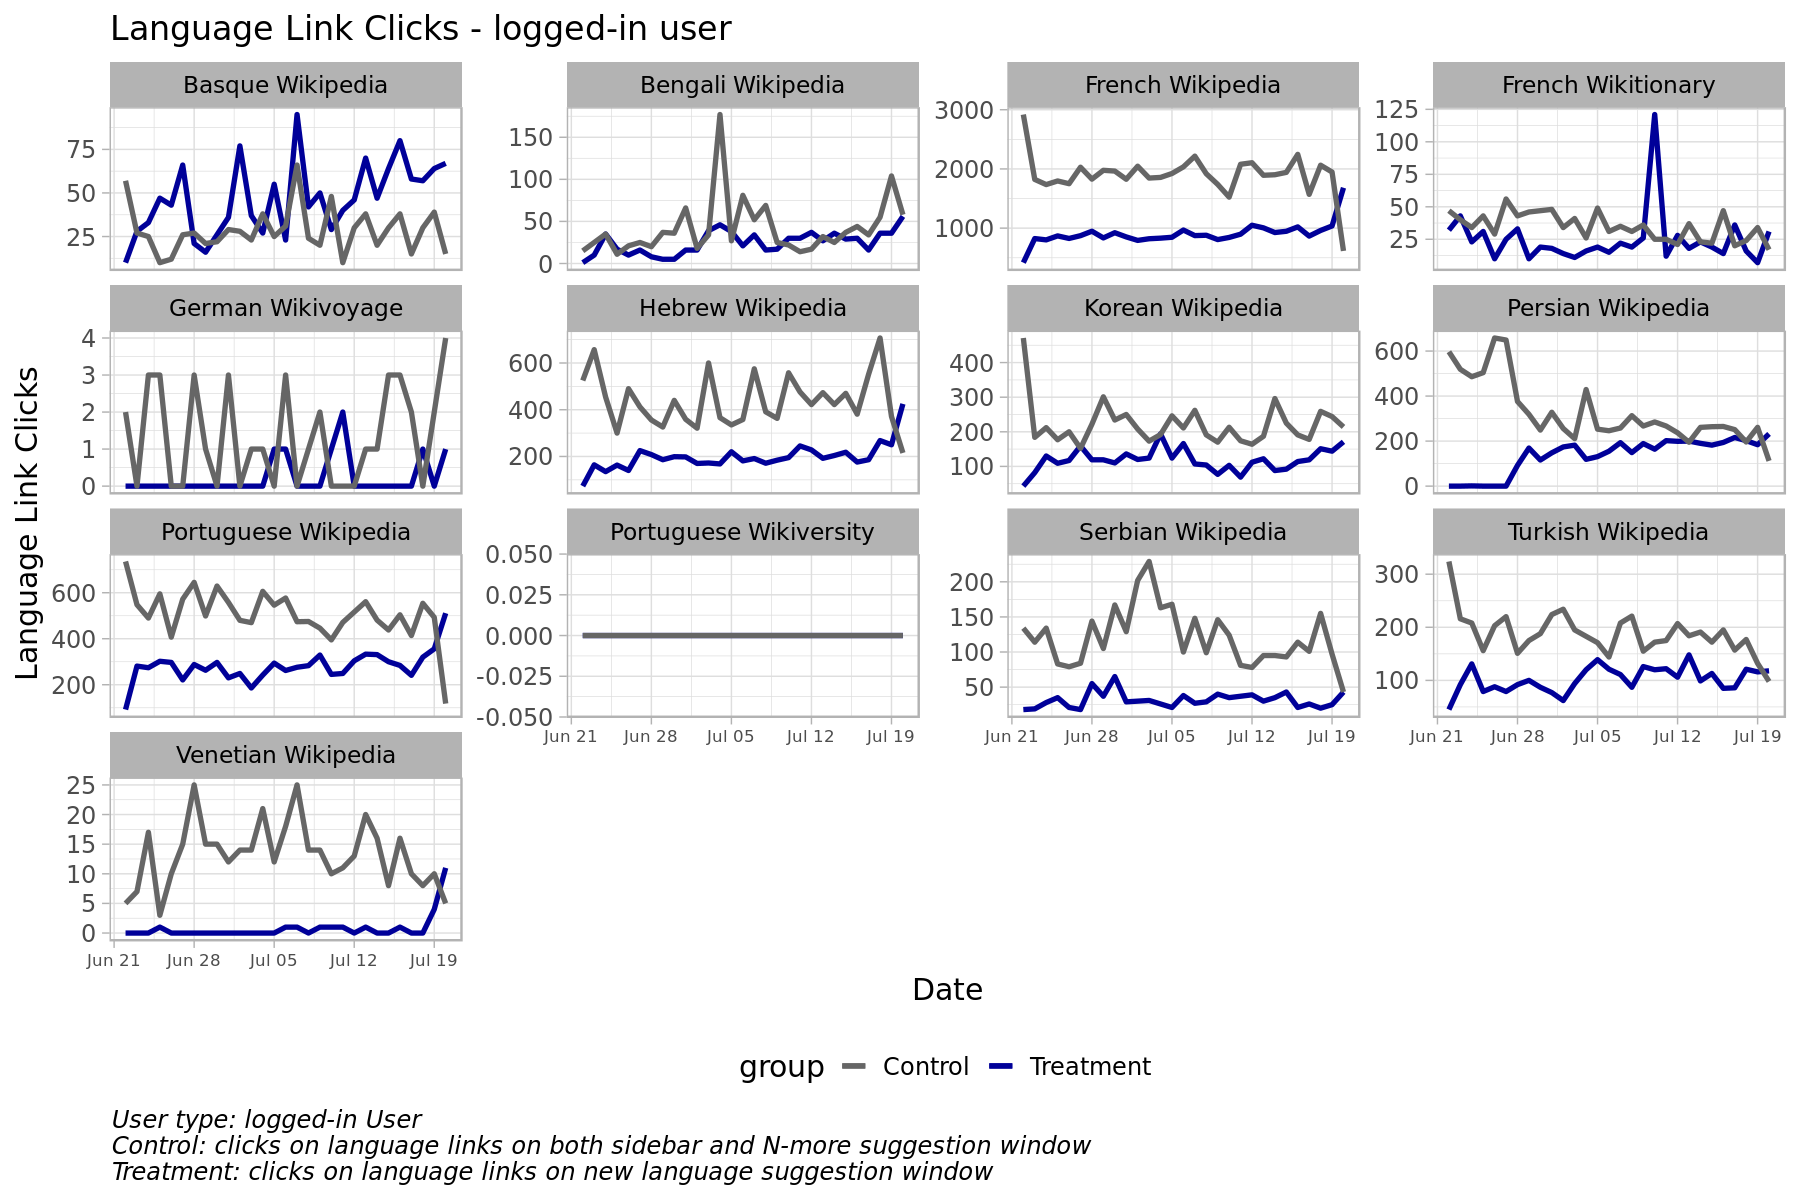

In [156]:
df_lang_clicks_g <- ggplot(data=df_lang_clicks, 
                                mapping=aes(x=date)) +
geom_line(aes(y=n_events_new_language_change , color="c2") , size = 1.5) +
geom_line(aes(y=n_events_control, color="c1") , size = 1.5) +
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
scale_color_manual(values= c("c1"="#666666", "c2"="#000099"), name = "group", labels = c("Control", "Treatment"))  +
labs(title = 'Language Link Clicks - logged-in user',
     x = 'Date',
     y = 'Language Link Clicks',
    caption = "User type: logged-in User
Control: clicks on language links on both sidebar and N-more suggestion window
Treatment: clicks on language links on new language suggestion window"
    ) + 
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
ggsave("Graphs_login/lang_link_clicks.png",
    plot = df_lang_clicks_g, width = 60, height = 30, units = "cm", dpi = "screen");
df_lang_clicks_g

In [35]:
# add column classifying events in AB testing
df_lang_clicks_AB <- df_lang_clicks %>%
    filter((date >= '2021-06-22' & date <= '2021-07-20' & wiki !='fawiki')| 
           date >= '2021-06-28' & date <= '2021-07-20' & wiki =='fawiki') %>%
    group_by(wiki_name) %>%
    summarize(control = sum(n_events_control), treatment= sum(n_events_new_language_change),  .groups = 'drop')

In [36]:
df_lang_clicks_AB

wiki_name,control,treatment
<chr>,<dbl>,<dbl>
Basque Wikipedia,824,1354
Bengali Wikipedia,1216,713
French Wikipedia,55119,26224
French Wikitionary,1011,711
German Wikivoyage,39,7
Hebrew Wikipedia,12675,5735
Korean Wikipedia,6401,3425
Persian Wikipedia,6099,3982
Portuguese Wikipedia,14698,8140


In [37]:
df_lang_clicks_AB_long <- pivot_longer(df_lang_clicks_AB, cols = c('control','treatment' ), names_to="group", values_to="lang_link_clicks")

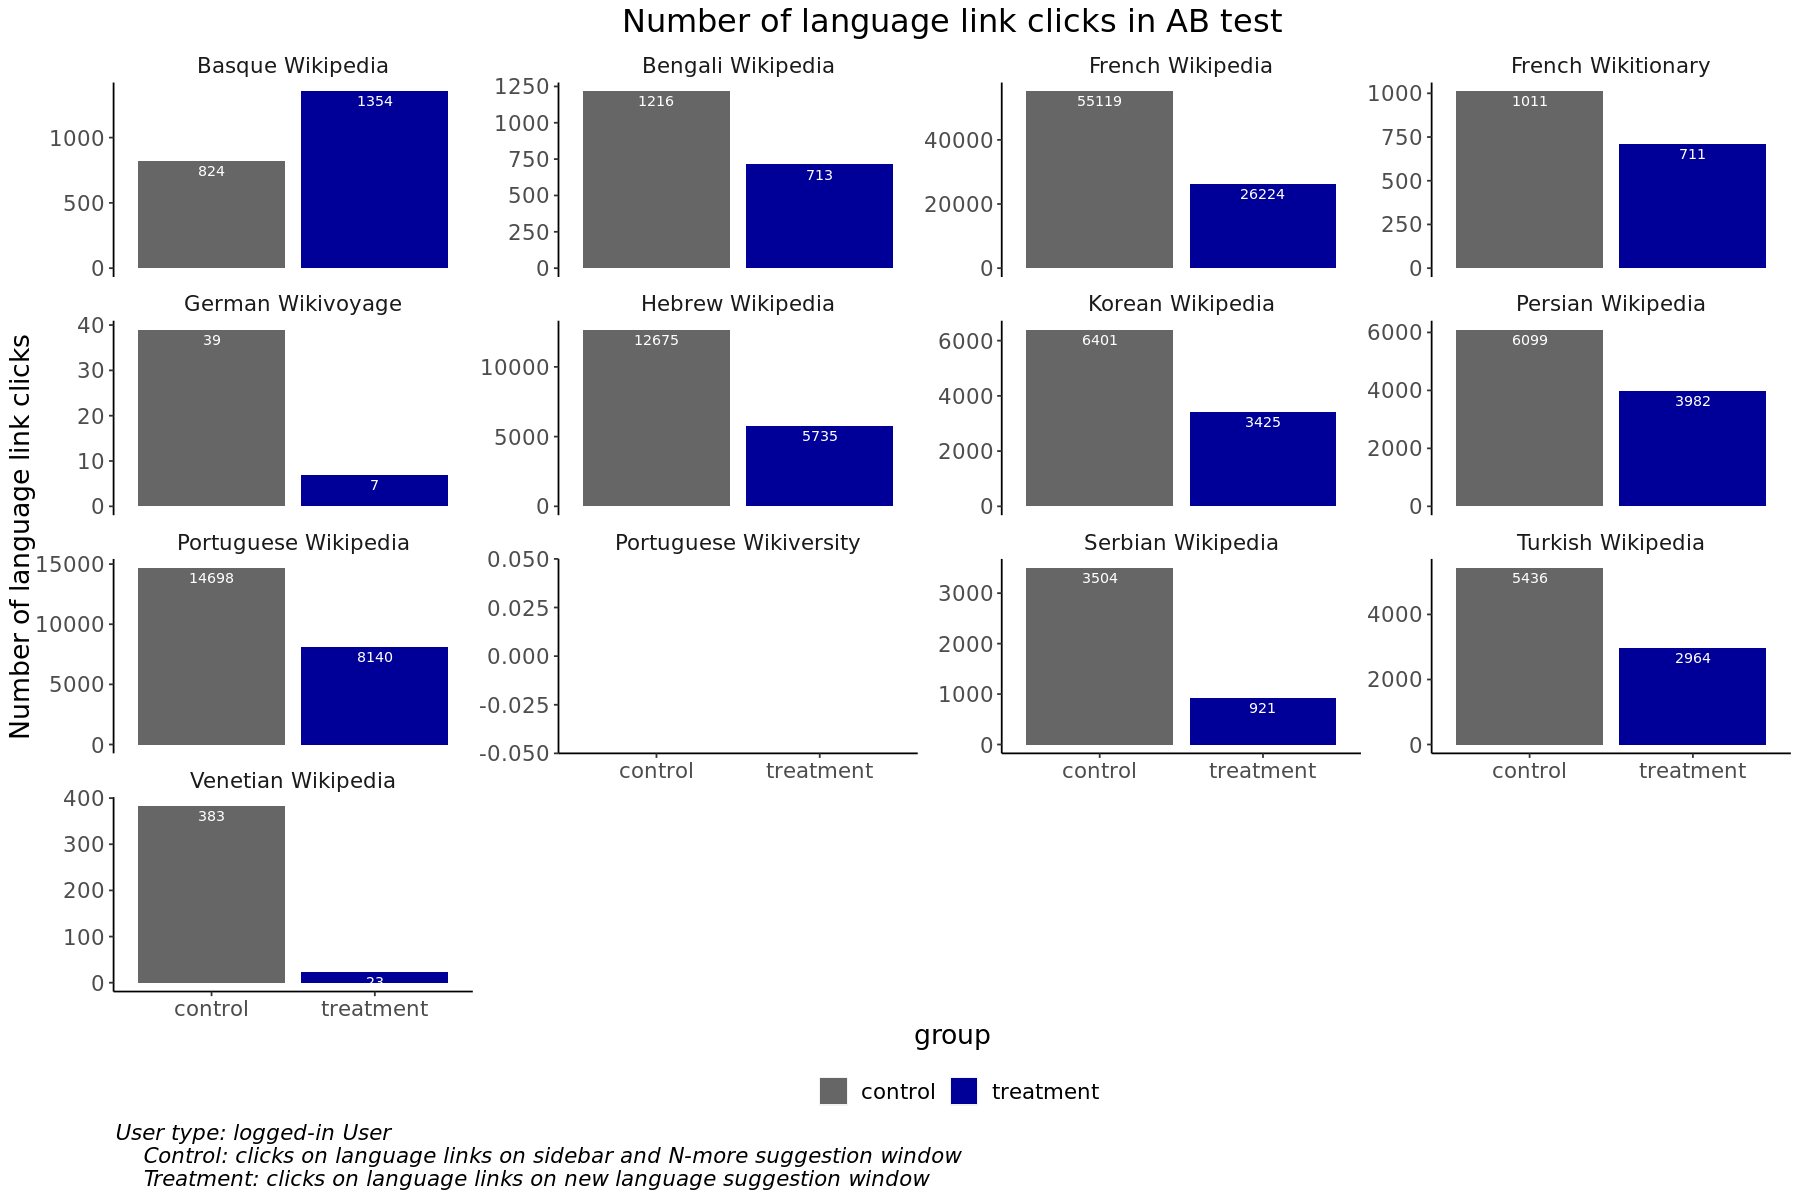

In [177]:
lang_clicks_barchart <- df_lang_clicks_AB_long %>%
        ggplot(aes(x = group, y= lang_link_clicks, fill=group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(lang_link_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of language link clicks",
             title = "Number of language link clicks in AB test",
             caption = "User type: logged-in User
    Control: clicks on language links on sidebar and N-more suggestion window
    Treatment: clicks on language links on new language suggestion window") +
    scale_fill_manual(values= c("control"="#666666", "treatment"="#000099"), name = "")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
lang_clicks_barchart

__Determine the percentage of changes__

In [178]:
ggsave("Graphs_login/lang_link_clicks_bar.png",
    plot = lang_clicks_barchart, width = 60, height = 30, units = "cm", dpi = "screen");

In [40]:
df_lang_clicks_AB <- df_lang_clicks_AB %>%
  mutate(
        pct_change= case_when(
        control==0&treatment>0 ~ 100,
        control==0&treatment==0 ~ 0,
        TRUE ~ round((treatment-control)/control * 100 , 2)
        ),
        pct= case_when(
        control==0&treatment>0 ~ 1,
        control==0&treatment==0 ~ 0,
        TRUE ~ round((treatment-control)/control , 4)
        )
 )



In [41]:
df_lang_clicks_AB

wiki_name,control,treatment,pct_change,pct
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,824,1354,64.32,0.6432
Bengali Wikipedia,1216,713,-41.37,-0.4137
French Wikipedia,55119,26224,-52.42,-0.5242
French Wikitionary,1011,711,-29.67,-0.2967
German Wikivoyage,39,7,-82.05,-0.8205
Hebrew Wikipedia,12675,5735,-54.75,-0.5475
Korean Wikipedia,6401,3425,-46.49,-0.4649
Persian Wikipedia,6099,3982,-34.71,-0.3471
Portuguese Wikipedia,14698,8140,-44.62,-0.4462


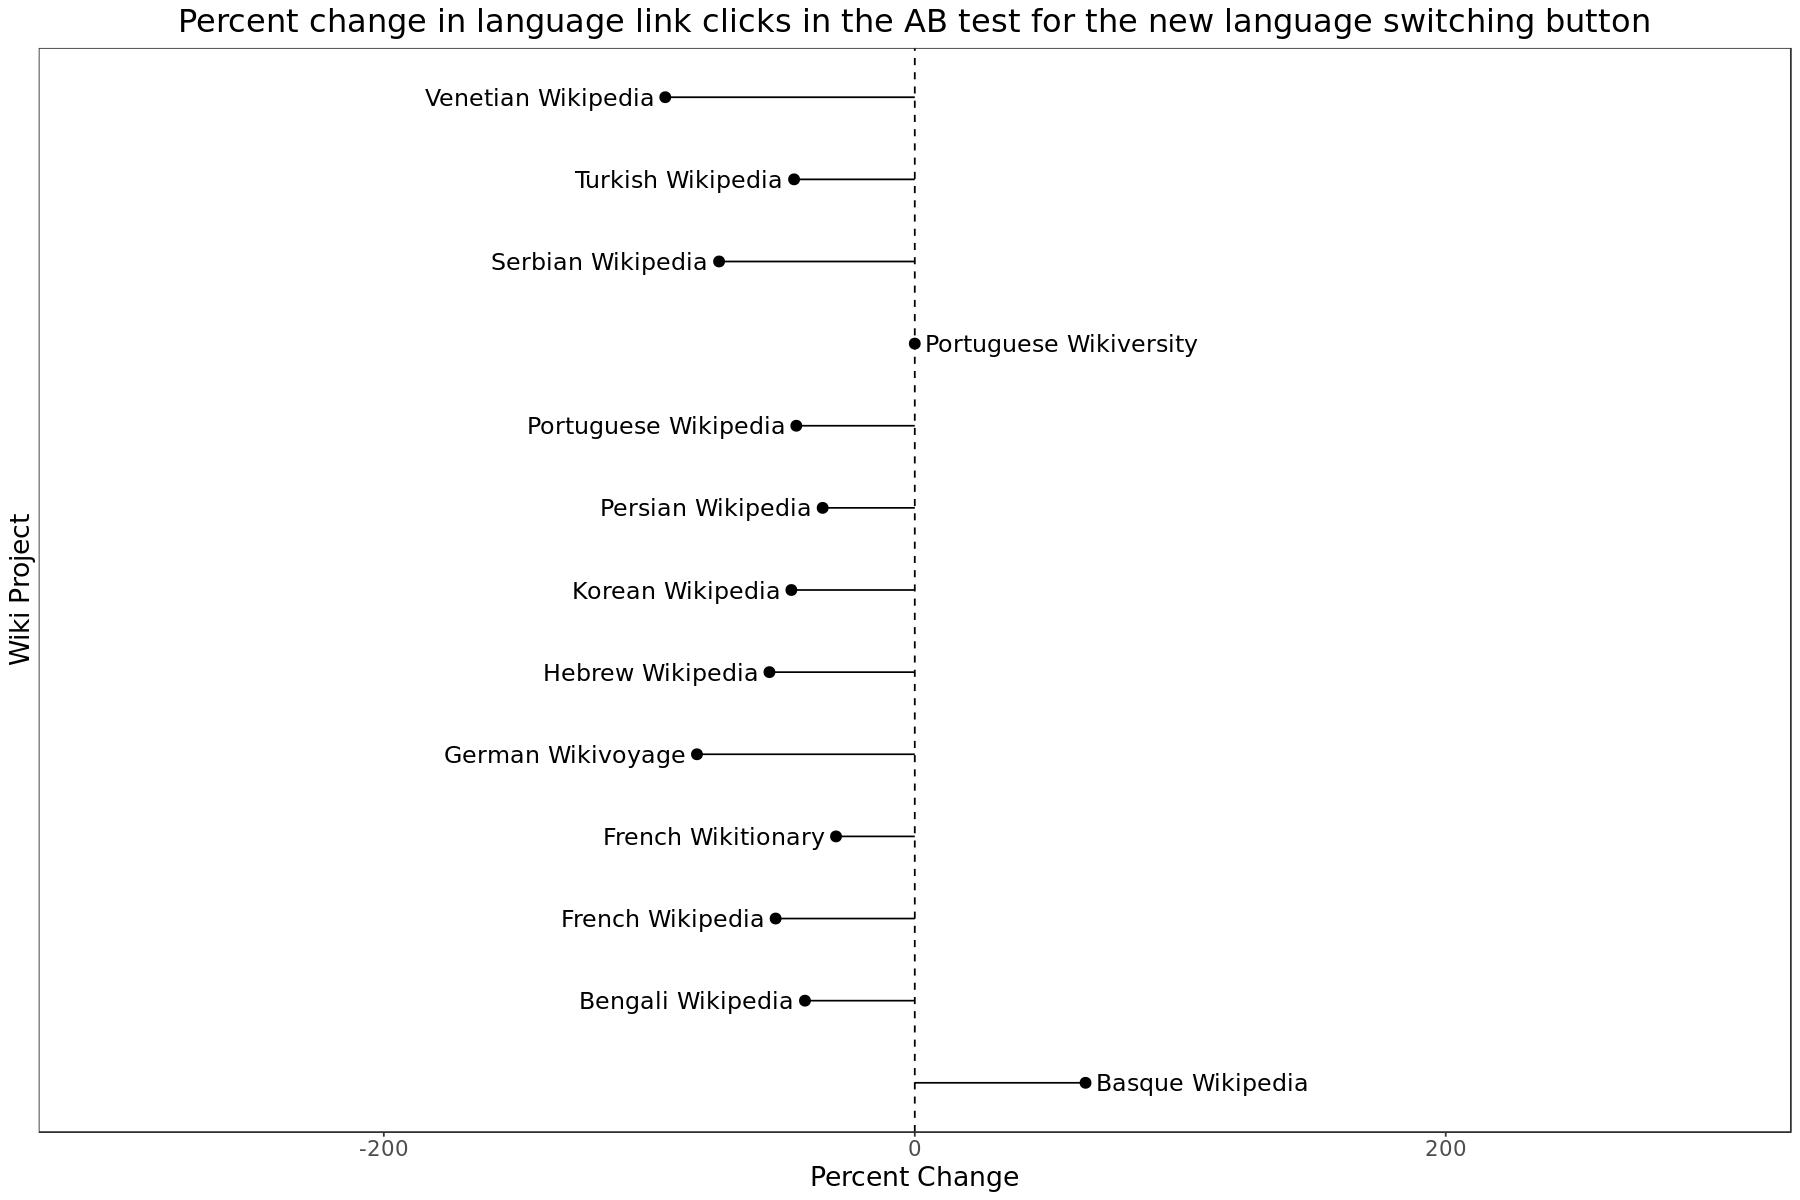

In [42]:
pct_g <- df_lang_clicks_AB %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in language link clicks in the AB test for the new language switching button") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

In [159]:
ggsave("Graphs_login/lang_link_clicks_pcg.png",
    plot = pct_g, width = 60, height = 30, units = "cm", dpi = "screen");

__Average percent change__

In [43]:
mean(filter(df_lang_clicks_AB, is.numeric(pct_change)&control>0)$pct_change)

[1] -44.57833

#### Modeling the impact

In [44]:
df_lang_clicks_AB

wiki_name,control,treatment,pct_change,pct
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,824,1354,64.32,0.6432
Bengali Wikipedia,1216,713,-41.37,-0.4137
French Wikipedia,55119,26224,-52.42,-0.5242
French Wikitionary,1011,711,-29.67,-0.2967
German Wikivoyage,39,7,-82.05,-0.8205
Hebrew Wikipedia,12675,5735,-54.75,-0.5475
Korean Wikipedia,6401,3425,-46.49,-0.4649
Persian Wikipedia,6099,3982,-34.71,-0.3471
Portuguese Wikipedia,14698,8140,-44.62,-0.4462


__Paired T-test of clicks in two groups__

We considered to use paired t-test to determine if there is statistical difference in the language link clicks between the two groups. However, we observed the data violated the prerequisite of normal distribution. 


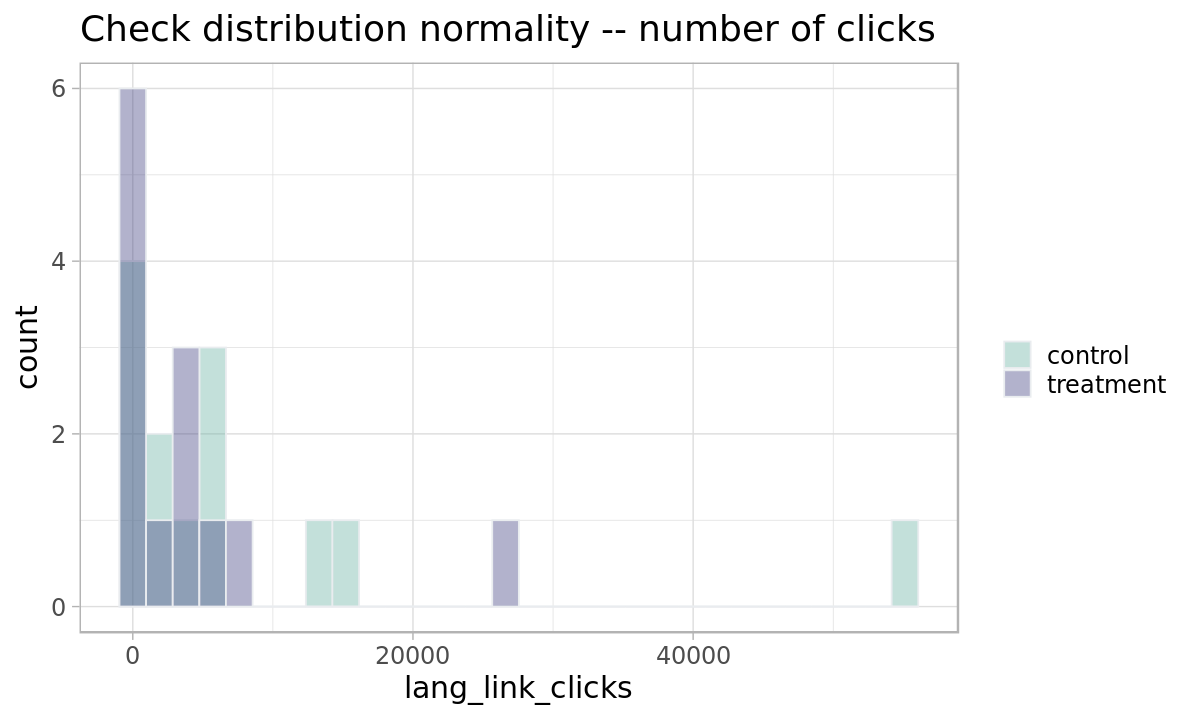

In [45]:
# Represent it
options(repr.plot.width = 10, repr.plot.height = 6)
p <- df_lang_clicks_AB_long %>%
  ggplot( aes(x=lang_link_clicks, fill=group)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=30) +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    labs ( title = "Check distribution normality -- number of clicks",
         fill="") +
    theme_light(base_size=18)
p

__One sample T-test of pecentage change in treatment group over control group__


We also reviewed the change percentage of clicks in the treatment group over clicks in the control group. Ran one-sample t-test to determine if the change percentage is less than 0. In this model, each wiki represents an observational unit.

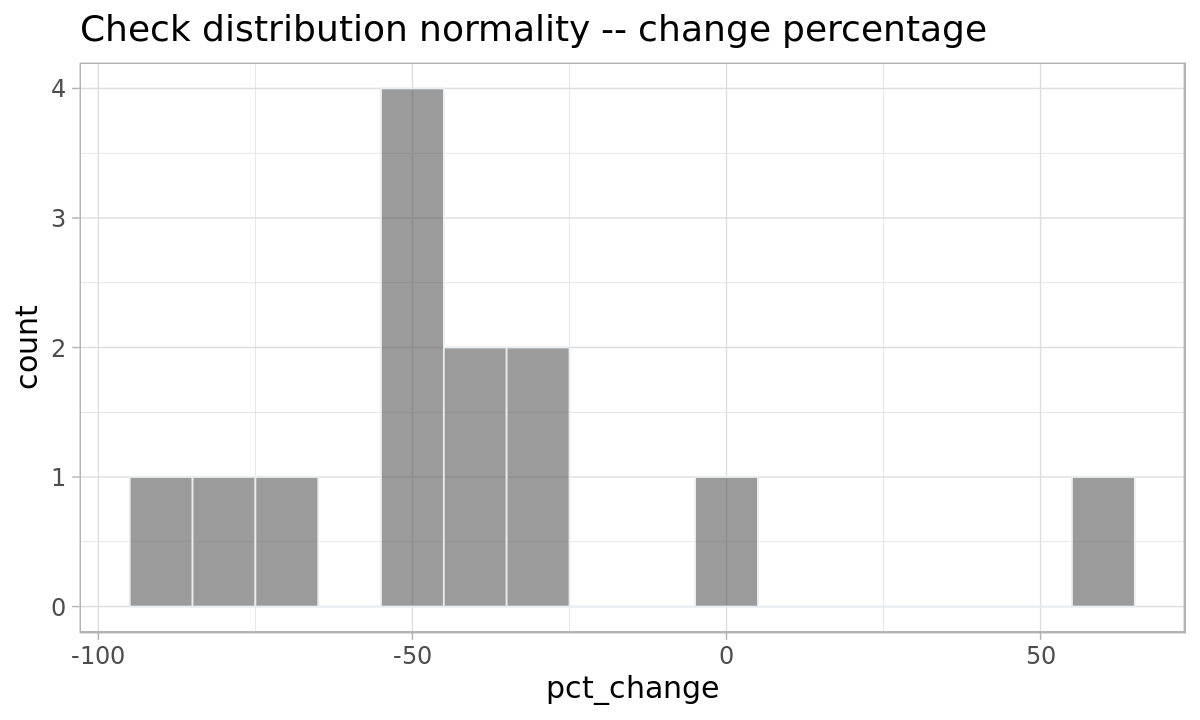

In [47]:
options(repr.plot.width = 10, repr.plot.height = 6)
p <- df_lang_clicks_AB %>%
    ggplot( aes(x=pct_change)) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity', binwidth=10) +
    labs ( title = "Check distribution normality -- change percentage") +
    theme_light(base_size=18)
p

Normality assumption holds.  

We use one-tailed t-test to test the null hypothesis: the change percentage of clicks in the treatment group over clicks in the control group is zero.  
Alternative hypothesis is: the change percentage of clicks in the treatment group over clicks in the control group is less than zero.


In [48]:
with(df_lang_clicks_AB, t.test(x=pct_change, y=NULL,mu=0, alternative = "less", paired = FALSE, 
       conf.level = 0.95 ))


	One Sample t-test

data:  pct_change
t = -3.7397, df = 12, p-value = 0.001412
alternative hypothesis: true mean is less than 0
95 percent confidence interval:
      -Inf -21.53813
sample estimates:
mean of x 
-41.14923 


__Conclusion:__

As the p-value < 0.05 and confidence interval is on the left side of 0, the alternative hypothesis holds. The change percentage, i.e. (treatment-control)*100/control, is significantly less than 0. We have sufficient statistical evidence to conclude that the clicks from the treatment group are less than the control group. 

__Summary__:

There was an average 44.57% decrease[^1] in total clicks on language links by logged-in users on the early adopter wikis in treatment group compared with control group. The decrease is contradicted with our hypothesis. It might be due to the lags in new feature adoption. Further investigation may be needed to identify possible reasons for this decrease.

[^1]: Calculated by taking the average of the percent changes observed on each early adopter wiki.



# Input Language Link Clicks

__New feature -- input language link clicks after new button clicks__
<img src="Figures/old_input_lang.png" width="600" height="400" align="center"/>

In [49]:
query_input_lang_clicks_new <- 
"
-- sessions where new lang button was selected
WITH new_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'compact-language-links-open'
    AND event.context = 'header'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    wiki
),

input_lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon = false
    AND event.action='ime-change'
    AND event.skinVersion = 'latest'
)

SELECT
    new_button.button_date,
    input_lang_switches.switch_date,
    new_button.session_id,
    new_button.wiki,
    new_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(input_lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    input_lang_switches.switch_context
FROM new_button
LEFT JOIN input_lang_switches ON
    new_button.session_id = input_lang_switches.session_id AND
    new_button.wiki = input_lang_switches.wiki
"

In [116]:
#new_input_lang_clicks <-  wmfdata::query_hive(query_input_lang_clicks_new)

In [52]:
new_input_lang_clicks_by_date <- new_input_lang_clicks %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(new_input_language_clicks = sum(language_switch), .groups='drop')

new_input_lang_clicks$switch_date <- as.Date(new_input_lang_clicks$switch_date, format = "%Y-%m-%d")

__Old feature -- input langauage link clicks after setting button clicks on sidebar__
<img src="Figures/new_input_lang.png" width="600" height="400" align="center"/>

In [53]:
query_input_language_old <- 
"
-- sessions where setting button was selected
WITH setting_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'settings-open'
    AND event.context = 'interlanguage'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    wiki
),

input_lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only anonymous users
    AND event.isanon = false
    AND event.action='ime-change' 
    AND event.skinVersion = 'latest'
)

SELECT
    setting_button.button_date,
    input_lang_switches.switch_date,
    setting_button.session_id,
    setting_button.wiki,
    setting_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(input_lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    input_lang_switches.switch_context
FROM setting_button
LEFT JOIN input_lang_switches ON
    setting_button.session_id = input_lang_switches.session_id AND
    setting_button.wiki = input_lang_switches.wiki
"

In [117]:
#old_input_lang_clicks <-  wmfdata::query_hive(query_input_language_old)

In [55]:
old_input_lang_clicks_by_date <- old_input_lang_clicks %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(old_input_language_clicks = sum(language_switch), .groups='drop')

old_input_lang_clicks_by_date$switch_date <- as.Date(old_input_lang_clicks_by_date$switch_date, format = "%Y-%m-%d")

In [56]:
df_input_clicks= expand.grid(date=date_seq, wiki=wiki_seq )

df_input_clicks <-  merge(df_input_clicks , new_input_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)

df_input_clicks <-  merge(df_input_clicks , old_input_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)

df_input_clicks[is.na(df_input_clicks)] <- 0

In [57]:
df_input_clicks <- df_input_clicks %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'),
)

In [59]:
options(repr.plot.width = 15, repr.plot.height = 10)

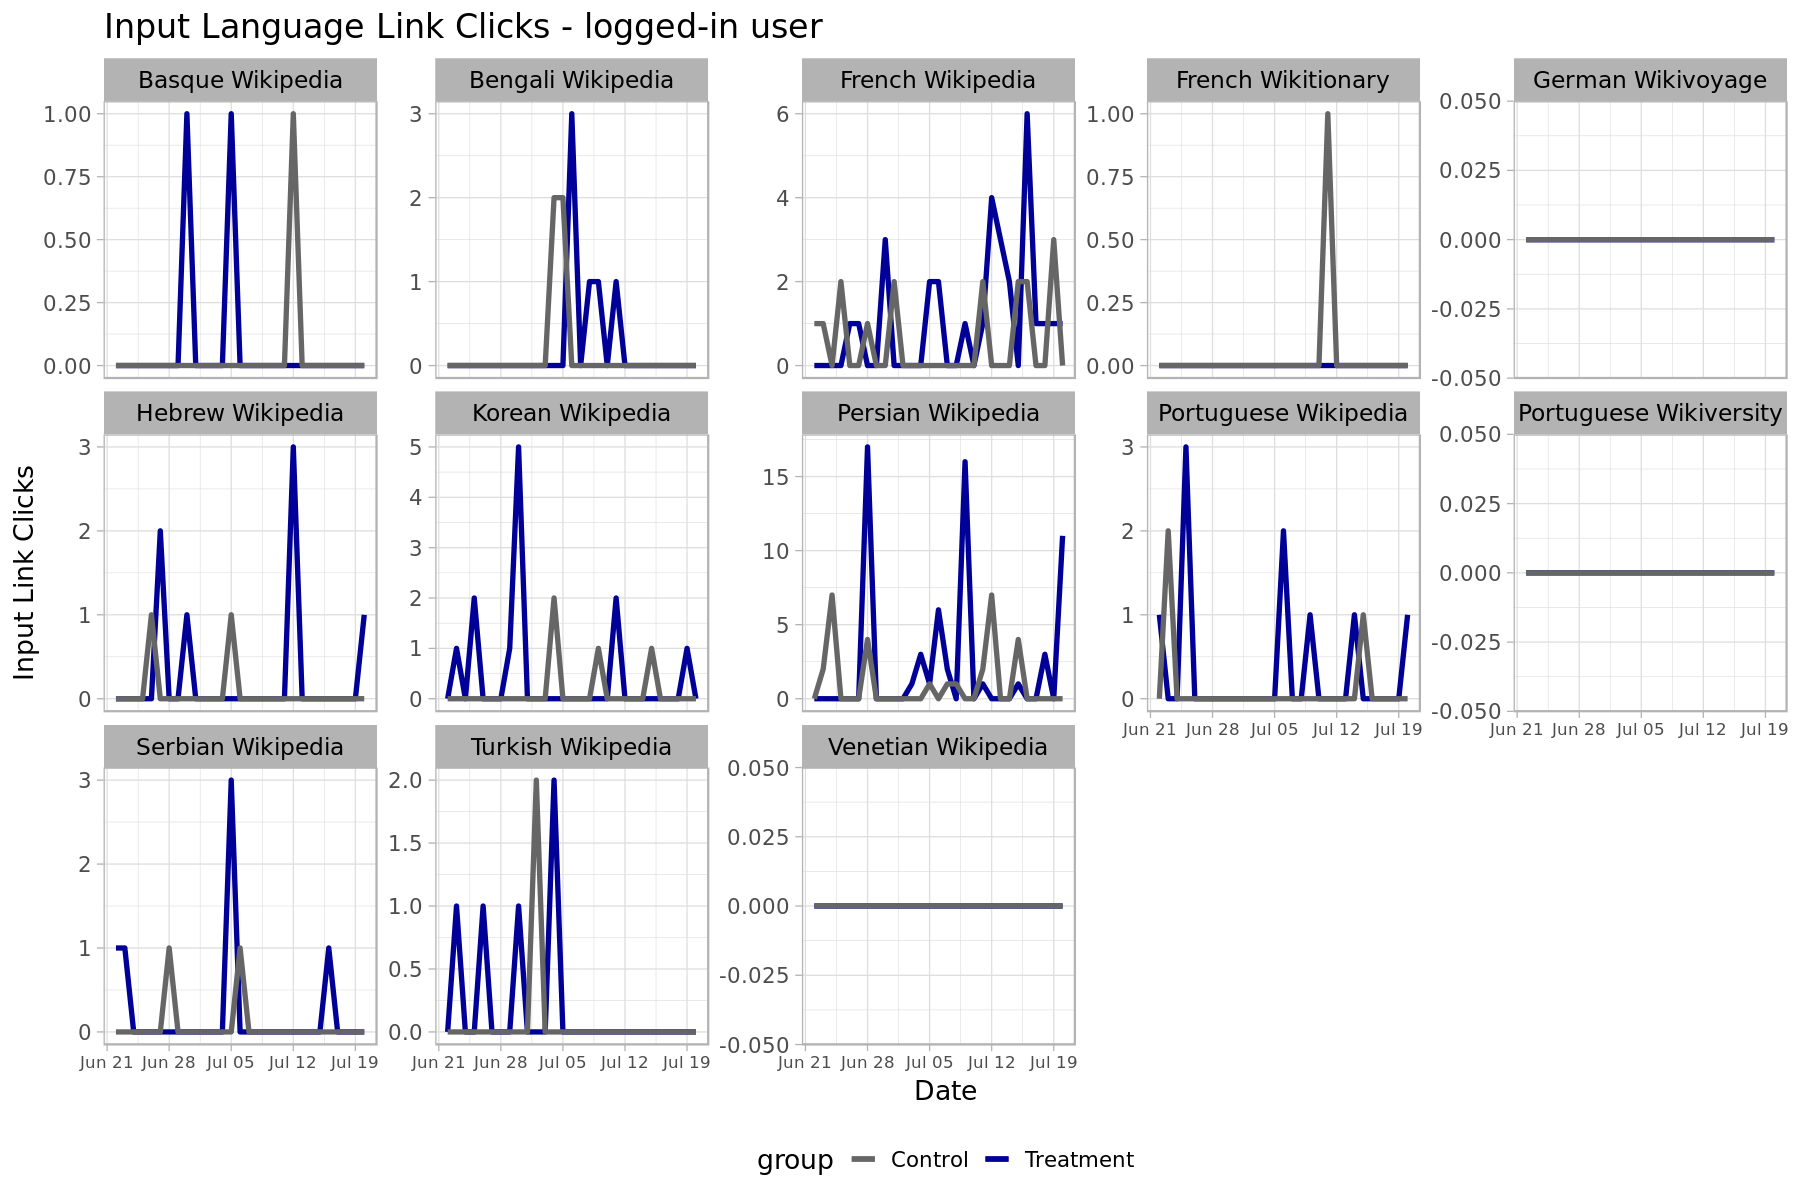

In [164]:
input_lang_click_g <- ggplot(data=filter( df_input_clicks,  (date >= '2021-06-22')&(date <= '2021-07-20')), 
                                mapping=aes(x=date)) +
geom_line(aes(y=new_input_language_clicks , color="c2") , size = 1.5) +
geom_line(aes(y=old_input_language_clicks, color="c1") , size = 1.5) +
facet_wrap(~wiki_name,nrow=3,scale = 'free_y')+
scale_color_manual(values= c("c1"="#666666", "c2"="#000099"), name = "group", labels = c("Control", "Treatment"))  +
labs(title = 'Input Language Link Clicks - logged-in user',
     x = 'Date',
     y = 'Input Link Clicks') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
ggsave("Graphs_login/input_lang.png",
    plot = input_lang_click_g , width = 60, height = 30, units = "cm", dpi = "screen");
input_lang_click_g

In [61]:

# add column classifying events in AB testing
df_input_clicks_AB <- df_input_clicks %>%
    filter((date >= '2021-06-22' & date <= '2021-07-20' & wiki !='fawiki')| 
           date >= '2021-06-28' & date <= '2021-07-20' & wiki =='fawiki') %>%
    group_by(wiki_name) %>%
    summarize(control = sum(old_input_language_clicks), treatment= sum(new_input_language_clicks),  .groups = 'drop')

In [62]:
df_input_clicks_AB

wiki_name,control,treatment
<chr>,<dbl>,<dbl>
Basque Wikipedia,1,2
Bengali Wikipedia,4,6
French Wikipedia,16,30
French Wikitionary,1,0
German Wikivoyage,0,0
Hebrew Wikipedia,2,7
Korean Wikipedia,4,12
Persian Wikipedia,20,62
Portuguese Wikipedia,3,9


In [63]:
df_input_clicks_AB_L <- pivot_longer(df_input_clicks_AB, cols = c('control','treatment' ), names_to="group", values_to="input_lang_clicks")

In [179]:

input_clicks_barchart <- df_input_clicks_AB_L %>%
        ggplot(aes(x = group, y= input_lang_clicks, fill=group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(input_lang_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of input language clicks",
             title = "Number of input language clicks in AB test",
             caption = "User type: logged-in User
Control: clicks on input language links on setting window
Treatment: clicks on input language links on new language suggestion window") +
     scale_fill_manual(values= c("treatment"="#000099", "control"="#666666"), name = "")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

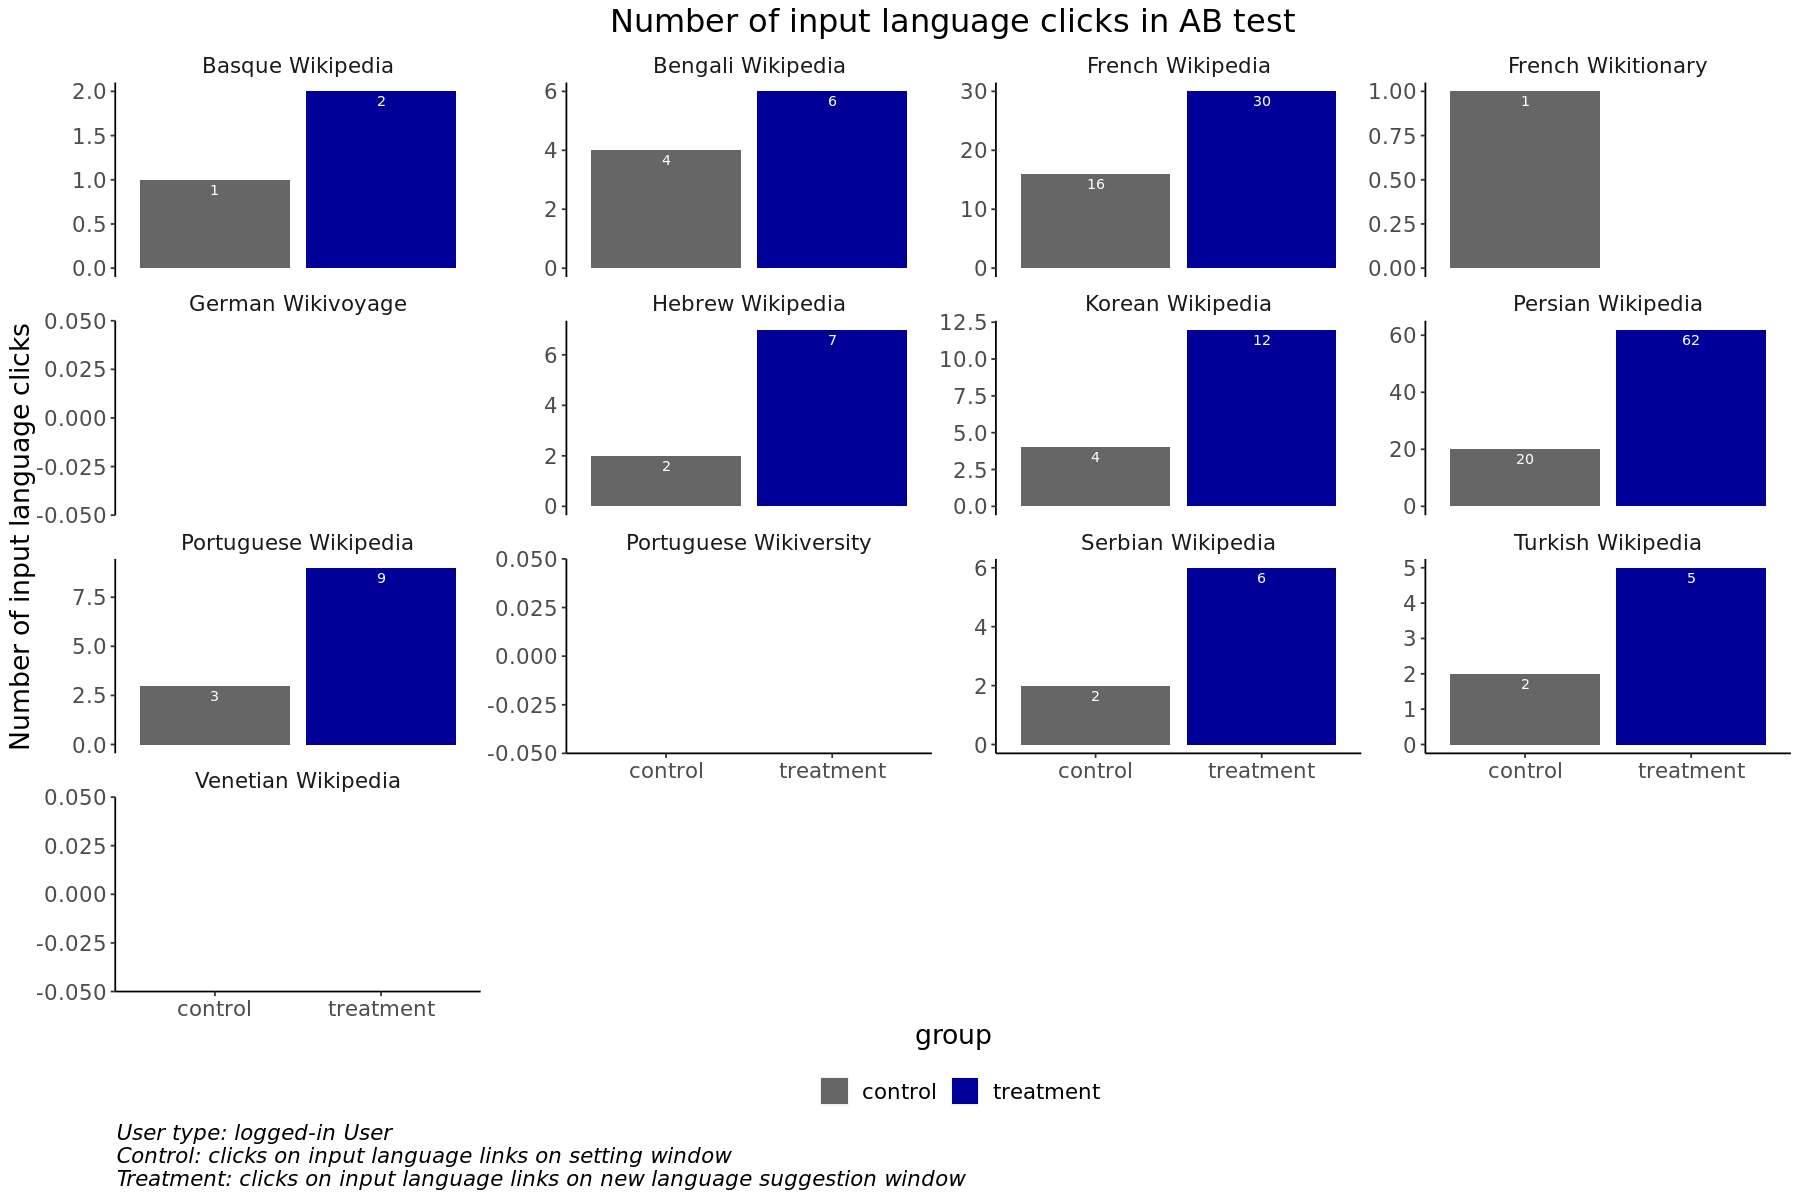

In [180]:
input_clicks_barchart

In [181]:


ggsave("Graphs_login/input_clicks_bar.png",
    plot = input_clicks_barchart , width = 60, height = 30, units = "cm", dpi = "screen");

__Determine the percentage of changes__

In [131]:
# determine percent change
df_input_clicks_AB <- df_input_clicks_AB %>%
  mutate(
        pct_change= case_when(
        control==0&treatment>0 ~ 100,
        control==0&treatment==0 ~ 0,
        TRUE ~ round((treatment-control)/control * 100 , 2)
        ),
        pct= case_when(
        control==0&treatment>0 ~ 1,
        control==0&treatment==0 ~ 0,
        TRUE ~ round((treatment-control)/control , 4)
        )
 )


In [132]:
df_input_clicks_AB

wiki_name,control,treatment,pct_change,pct
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,1,2,100.0,1.000
Bengali Wikipedia,4,6,50.0,0.500
French Wikipedia,16,30,87.5,0.875
French Wikitionary,1,0,-100.0,-1.000
German Wikivoyage,0,0,0.0,0.000
Hebrew Wikipedia,2,7,250.0,2.500
Korean Wikipedia,4,12,200.0,2.000
Persian Wikipedia,20,62,210.0,2.100
Portuguese Wikipedia,3,9,200.0,2.000


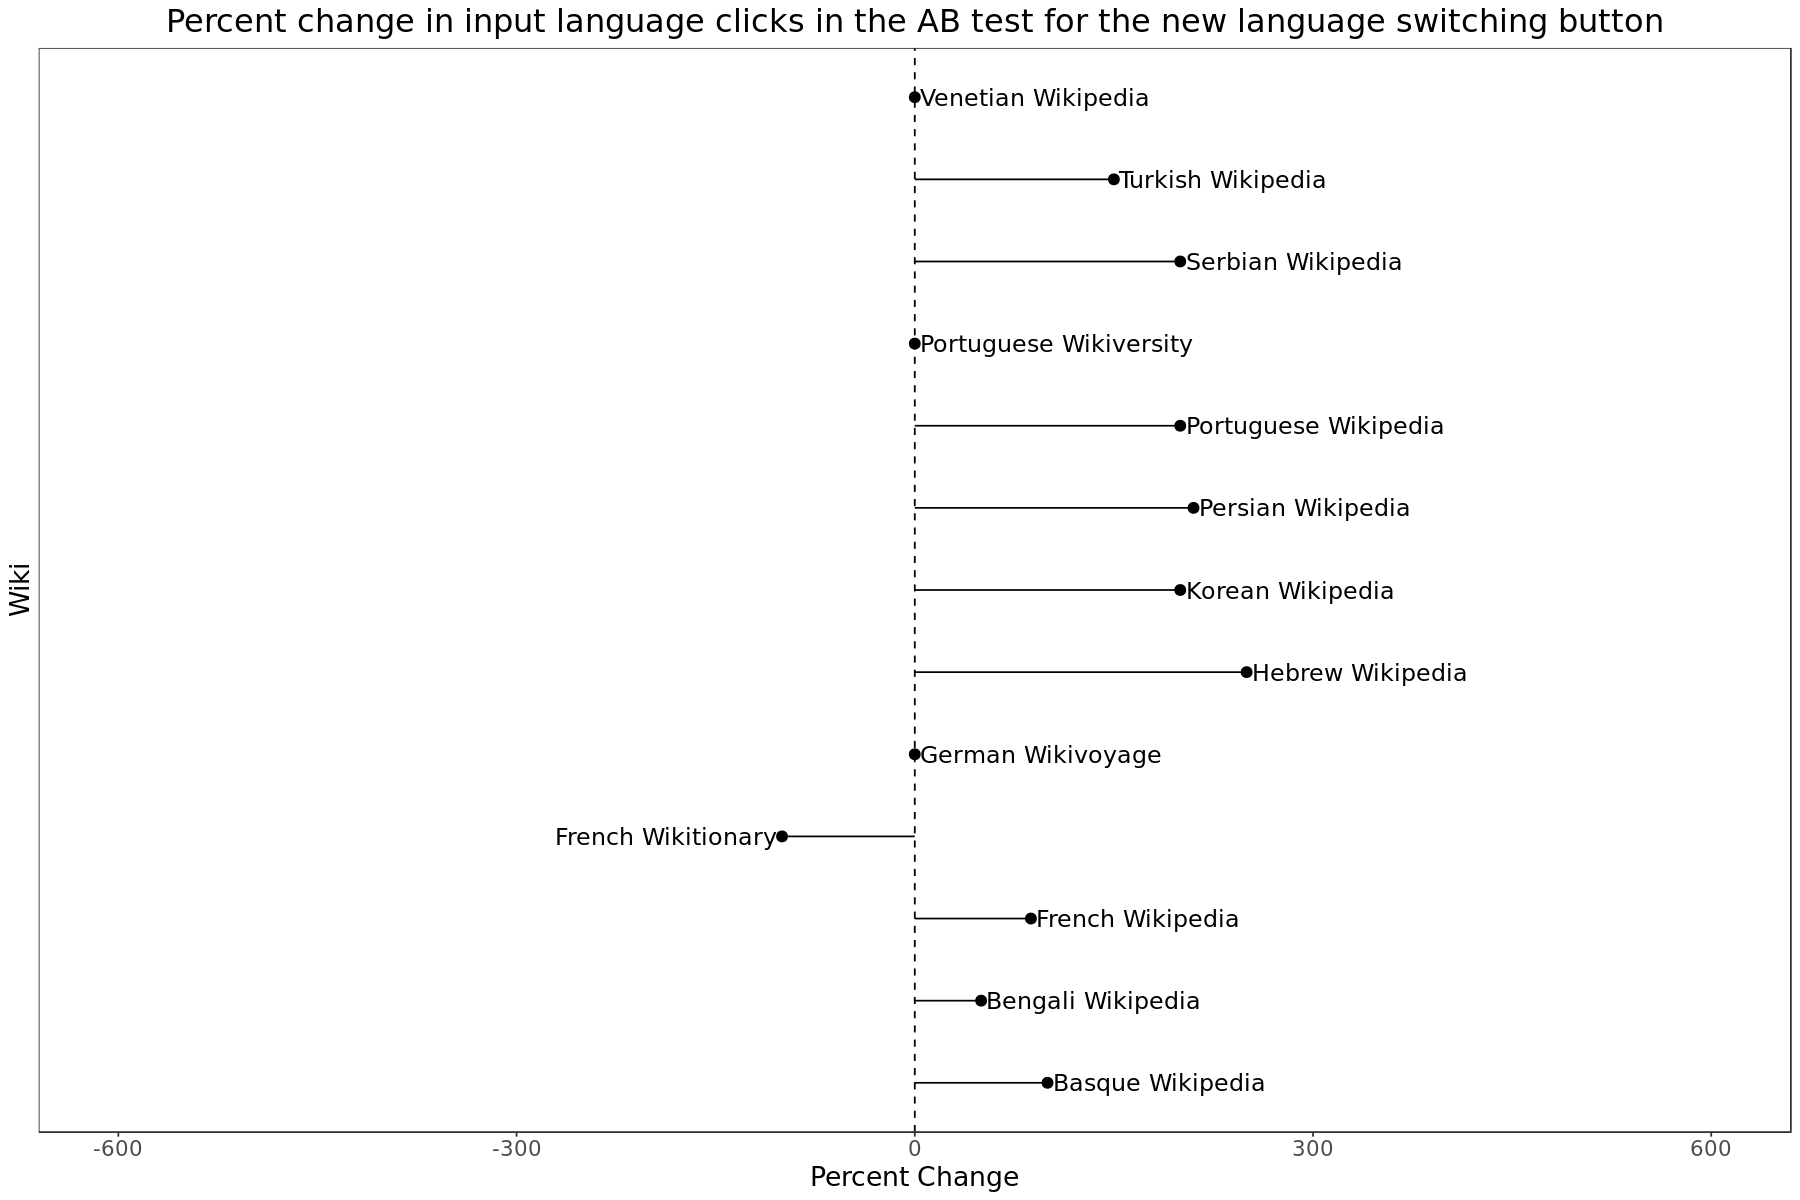

In [133]:

# chart percent change in logged-in users between control and treatment groups for each of the early adopter wikis

pct_input_g <- df_input_clicks_AB %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in input language clicks in the AB test for the new language switching button") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_input_g 



In [166]:

ggsave("Graphs_login/input_clicks_pct.png",
    plot = pct_input_g , width = 60, height = 30, units = "cm", dpi = "screen");

__Average percent change__

In [134]:
mean((filter(df_input_clicks_AB, is.numeric(pct_change) & control>0))$pct_change, na.rm=TRUE)

[1] 134.75

__Summary:__ 

There was an average 134.75% increase[^2] in total clicks on input language links by logged-in users on the early adopter wikis in treatment group (with deployment of the new language feature). The average is driven upwards mainly by wikis with low activities. 

The activities of input language switch is low cross wikis, too less to statistically model the impact.

[^2]: Calculated by taking the average of the percent changes observed on each early adopter wiki.

# Interface Language Link Clicks

__New feature -- interface language link clicks after new button clicks__
<img src="Figures/old_interface_lang.png" width="600" height="400" align="center"/>

In [74]:
query_interface_language_clicks_new <- 
"
-- sessions where new lang button was selected
WITH new_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    event.isanon,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'compact-language-links-open'
    AND event.context = 'header'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    event.isanon,
    wiki
),

interface_lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    event.isanon,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'language-change'
    AND  event.context='interface'
    AND event.skinVersion = 'latest'
)

SELECT
    new_button.button_date,
    interface_lang_switches.switch_date,
    new_button.session_id,
    new_button.isanon,
    new_button.wiki,
    new_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(interface_lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    interface_lang_switches.switch_context
FROM new_button
LEFT JOIN interface_lang_switches ON
    new_button.session_id = interface_lang_switches.session_id AND
    new_button.wiki = interface_lang_switches.wiki AND
    new_button.isanon = interface_lang_switches.isanon
"

In [118]:
#new_interface_language_clicks <-  wmfdata::query_hive(query_interface_language_clicks_new)

In [76]:
new_interface_lang_clicks_by_date <- new_interface_language_clicks %>%
    filter(language_switch==1) %>%
    group_by( wiki, switch_date) %>%
    summarize(new_interface_language_clicks = sum(language_switch),.groups="drop")

new_interface_lang_clicks_by_date$switch_date <- as.Date(new_interface_lang_clicks_by_date$switch_date)


__Old feature -- interface langauage link clicks after setting button clicks on sidebar__
<img src="Figures/new_interface_lang.png" width="600" height="400" align="center"/>

In [77]:
query_interface_language_click_old <- 
"
-- sessions where setting button was selected
WITH setting_button AS (
SELECT
    MIN(TO_DATE(dt)) as button_date,
    event.web_session_id as session_id,
    event.context as open_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'settings-open'
    AND event.context = 'interlanguage'
    AND event.skinVersion = 'latest'
GROUP BY 
    event.web_session_id,
    event.context,
    wiki
),

interface_lang_switches AS (
  SELECT
    TO_DATE(dt) as switch_date,
    event.web_session_id as session_id,
    event.context as switch_context,
    wiki as wiki
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7,8) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged-in users
    AND event.isanon =false
    AND event.action = 'language-change'
    AND  event.context='interface'
    AND event.skinVersion = 'latest'
)

SELECT
    setting_button.button_date,
    interface_lang_switches.switch_date,
    setting_button.session_id,
    setting_button.wiki,
    setting_button.open_context,
-- sessions with lang switch that occured after button clicks
    IF(interface_lang_switches.session_id IS NOT NULL AND switch_date >= button_date, 1, 0) AS language_switch,
    interface_lang_switches.switch_context
FROM setting_button
LEFT JOIN interface_lang_switches ON
    setting_button.session_id = interface_lang_switches.session_id AND
    setting_button.wiki = interface_lang_switches.wiki
"

In [119]:
#old_interface_language_clicks <-  wmfdata::query_hive(query_interface_language_click_old)

In [80]:
df_interface_clicks= expand.grid(date=date_seq, wiki=wiki_seq )

df_interface_clicks <-  merge(df_interface_clicks , new_interface_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)

df_interface_clicks <-  merge(df_interface_clicks , old_interface_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)

df_interface_clicks[is.na(df_interface_clicks)] <- 0

In [81]:
df_interface_clicks <- df_interface_clicks %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia'),
)

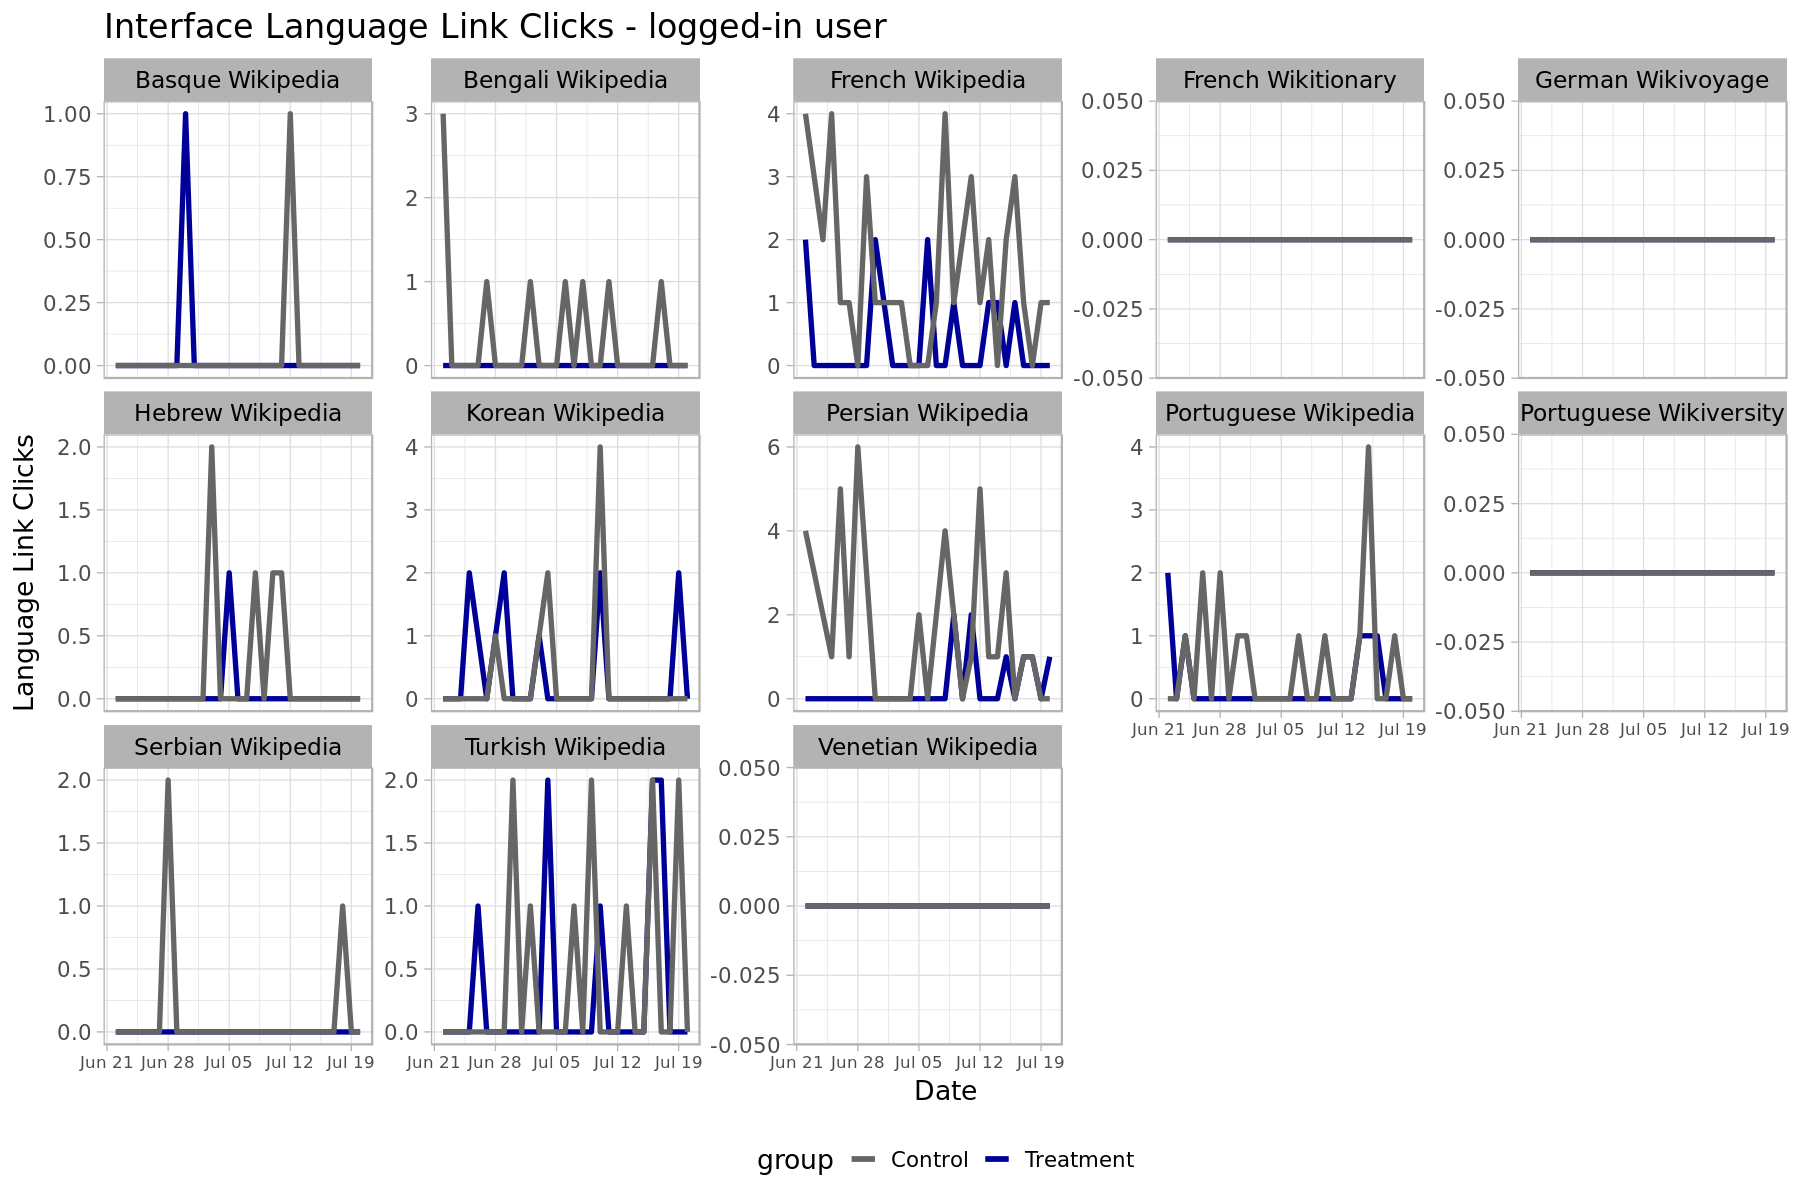

In [168]:
interface_lang_click_g <- ggplot(data=filter( df_interface_clicks,  (date >= '2021-06-22')&(date <= '2021-07-20')), 
                                mapping=aes(x=date)) +
geom_line(aes(y=new_interface_language_clicks , color="c2") , size = 1.5) +
geom_line(aes(y=old_interface_language_clicks, color="c1") , size = 1.5) +
facet_wrap(~wiki_name,nrow=3,scale = 'free_y')+
scale_color_manual(values= c("c1"="#666666", "c2"="#000099"), name = "group", labels = c("Control", "Treatment"))  +
labs(title = 'Interface Language Link Clicks - logged-in user',
     x = 'Date',
     y = 'Language Link Clicks') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
ggsave("Graphs_login/interface_lang.png",
    plot = interface_lang_click_g , width = 60, height = 30, units = "cm", dpi = "screen");

interface_lang_click_g

In [83]:

# add column classifying events in AB testing
df_interface_clicks_AB <- df_interface_clicks %>%
    filter((date >= '2021-06-22' & date <= '2021-07-20' & wiki !='fawiki')| 
           date >= '2021-06-28' & date <= '2021-07-20' & wiki =='fawiki') %>%
    group_by(wiki_name) %>%
    summarize(control = sum(old_interface_language_clicks), treatment= sum(new_interface_language_clicks),  .groups = 'drop')

In [84]:
df_interface_clicks_AB

wiki_name,control,treatment
<chr>,<dbl>,<dbl>
Basque Wikipedia,1,1
Bengali Wikipedia,9,0
French Wikipedia,44,11
French Wikitionary,0,0
German Wikivoyage,0,0
Hebrew Wikipedia,5,1
Korean Wikipedia,8,11
Persian Wikipedia,32,8
Portuguese Wikipedia,15,6


In [85]:
df_interface_clicks_AB_L <- pivot_longer(df_interface_clicks_AB, cols = c('control','treatment' ), names_to="group", values_to="interface_lang_clicks")

In [174]:

interface_clicks_barchart <- df_interface_clicks_AB_L %>%
        ggplot(aes(x = group, y= interface_lang_clicks, fill=group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(interface_lang_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of interface language clicks",
             title = "Number of interface language clicks",
             caption = "User type: logged-in User
Control: clicks on interface language links on setting window
Treatment: clicks on interface language links on new language suggestion window") +
     scale_fill_manual(values= c("treatment"="#000099", "control"="#666666"), name = "")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

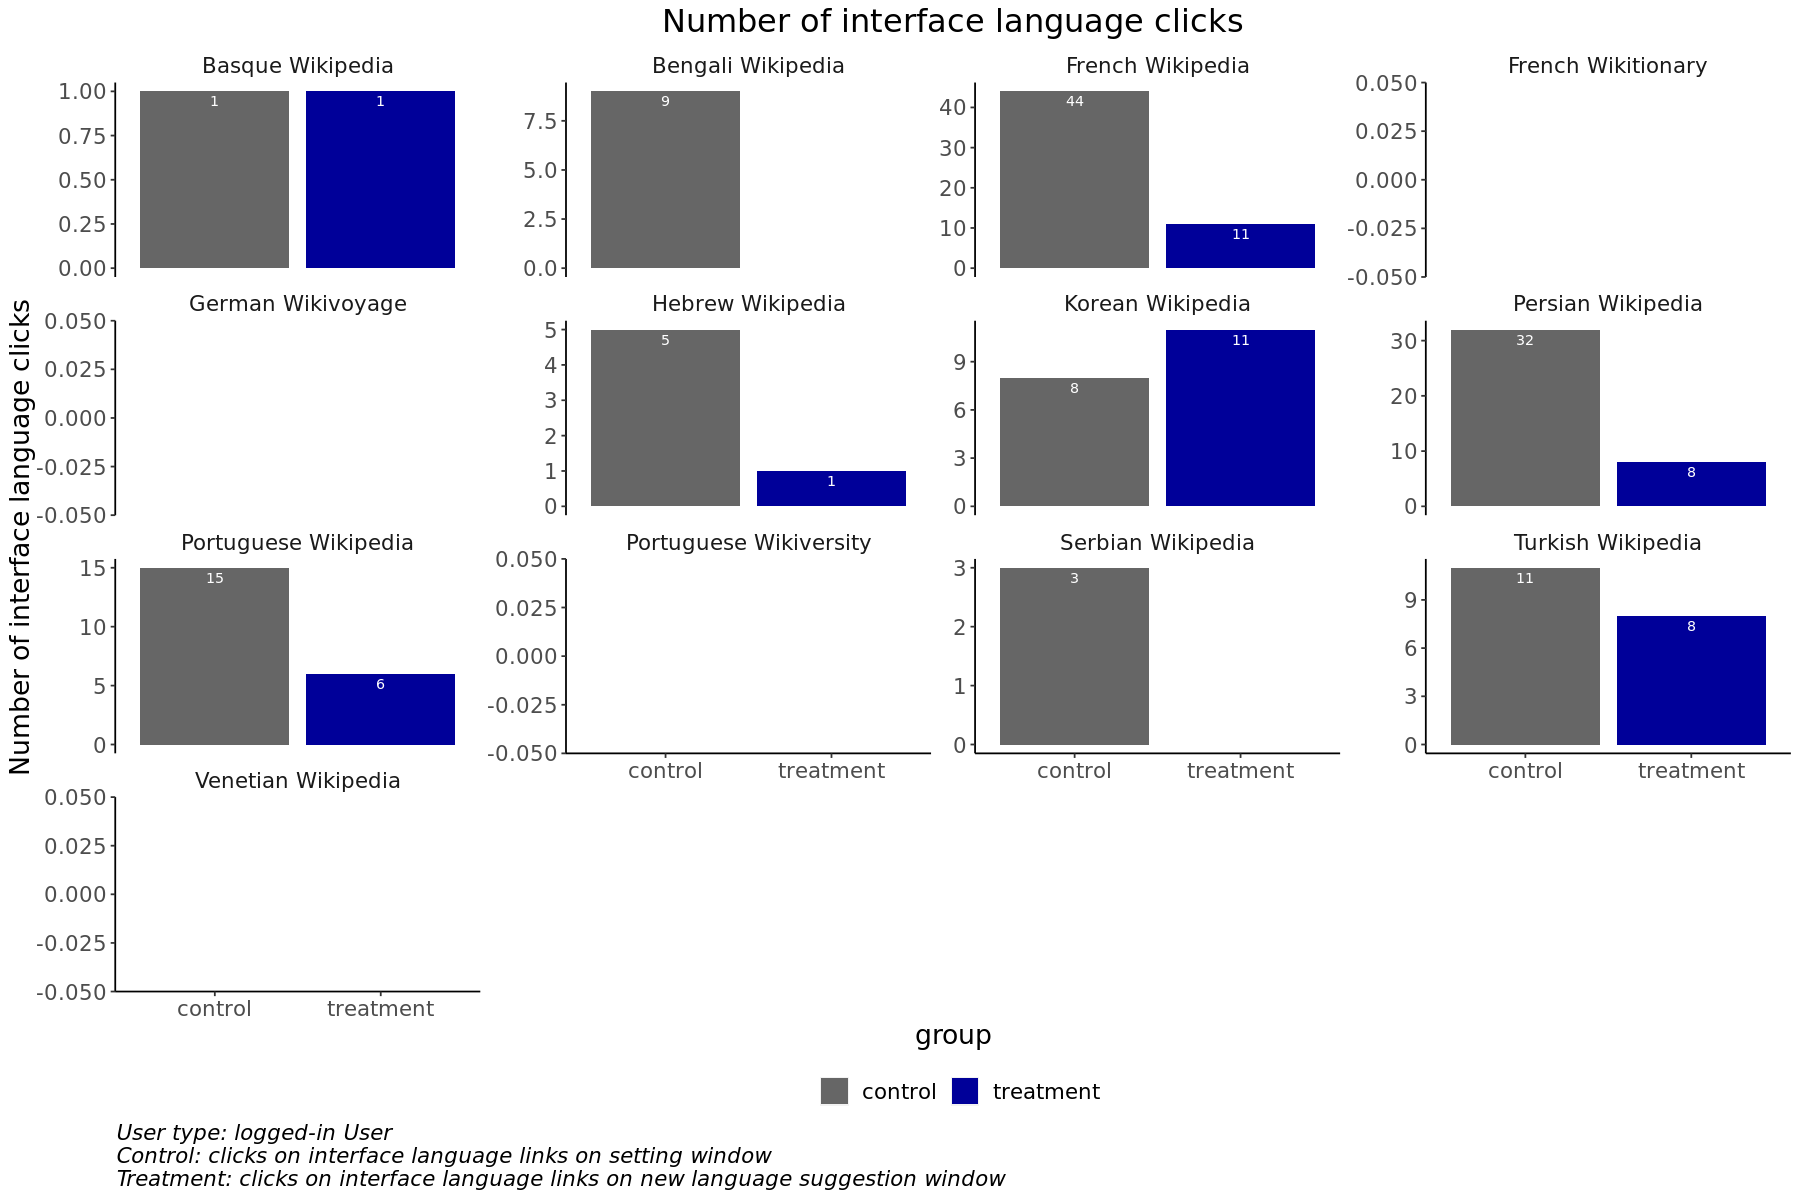

In [175]:
interface_clicks_barchart

In [176]:

ggsave("Graphs_login/interface_lang_bar.png",
    plot = interface_clicks_barchart , width = 60, height = 30, units = "cm", dpi = "screen");

__Determine the percentage of changes__

In [135]:
# determine percent change
df_interface_clicks_AB <- df_interface_clicks_AB %>%
  mutate(
        pct_change= case_when(
        control==0&treatment>0 ~ 100,
        control==0&treatment==0 ~ 0,
        TRUE ~ round((treatment-control)/control * 100 , 2)
        ),
        pct= case_when(
        control==0&treatment>0 ~ 1,
        control==0&treatment==0 ~ 0,
        TRUE ~ round((treatment-control)/control , 4)
        )
 )

In [136]:
df_interface_clicks_AB

wiki_name,control,treatment,pct_change,pct
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,1,1,0.00,0.0000
Bengali Wikipedia,9,0,-100.00,-1.0000
French Wikipedia,44,11,-75.00,-0.7500
French Wikitionary,0,0,0.00,0.0000
German Wikivoyage,0,0,0.00,0.0000
Hebrew Wikipedia,5,1,-80.00,-0.8000
Korean Wikipedia,8,11,37.50,0.3750
Persian Wikipedia,32,8,-75.00,-0.7500
Portuguese Wikipedia,15,6,-60.00,-0.6000


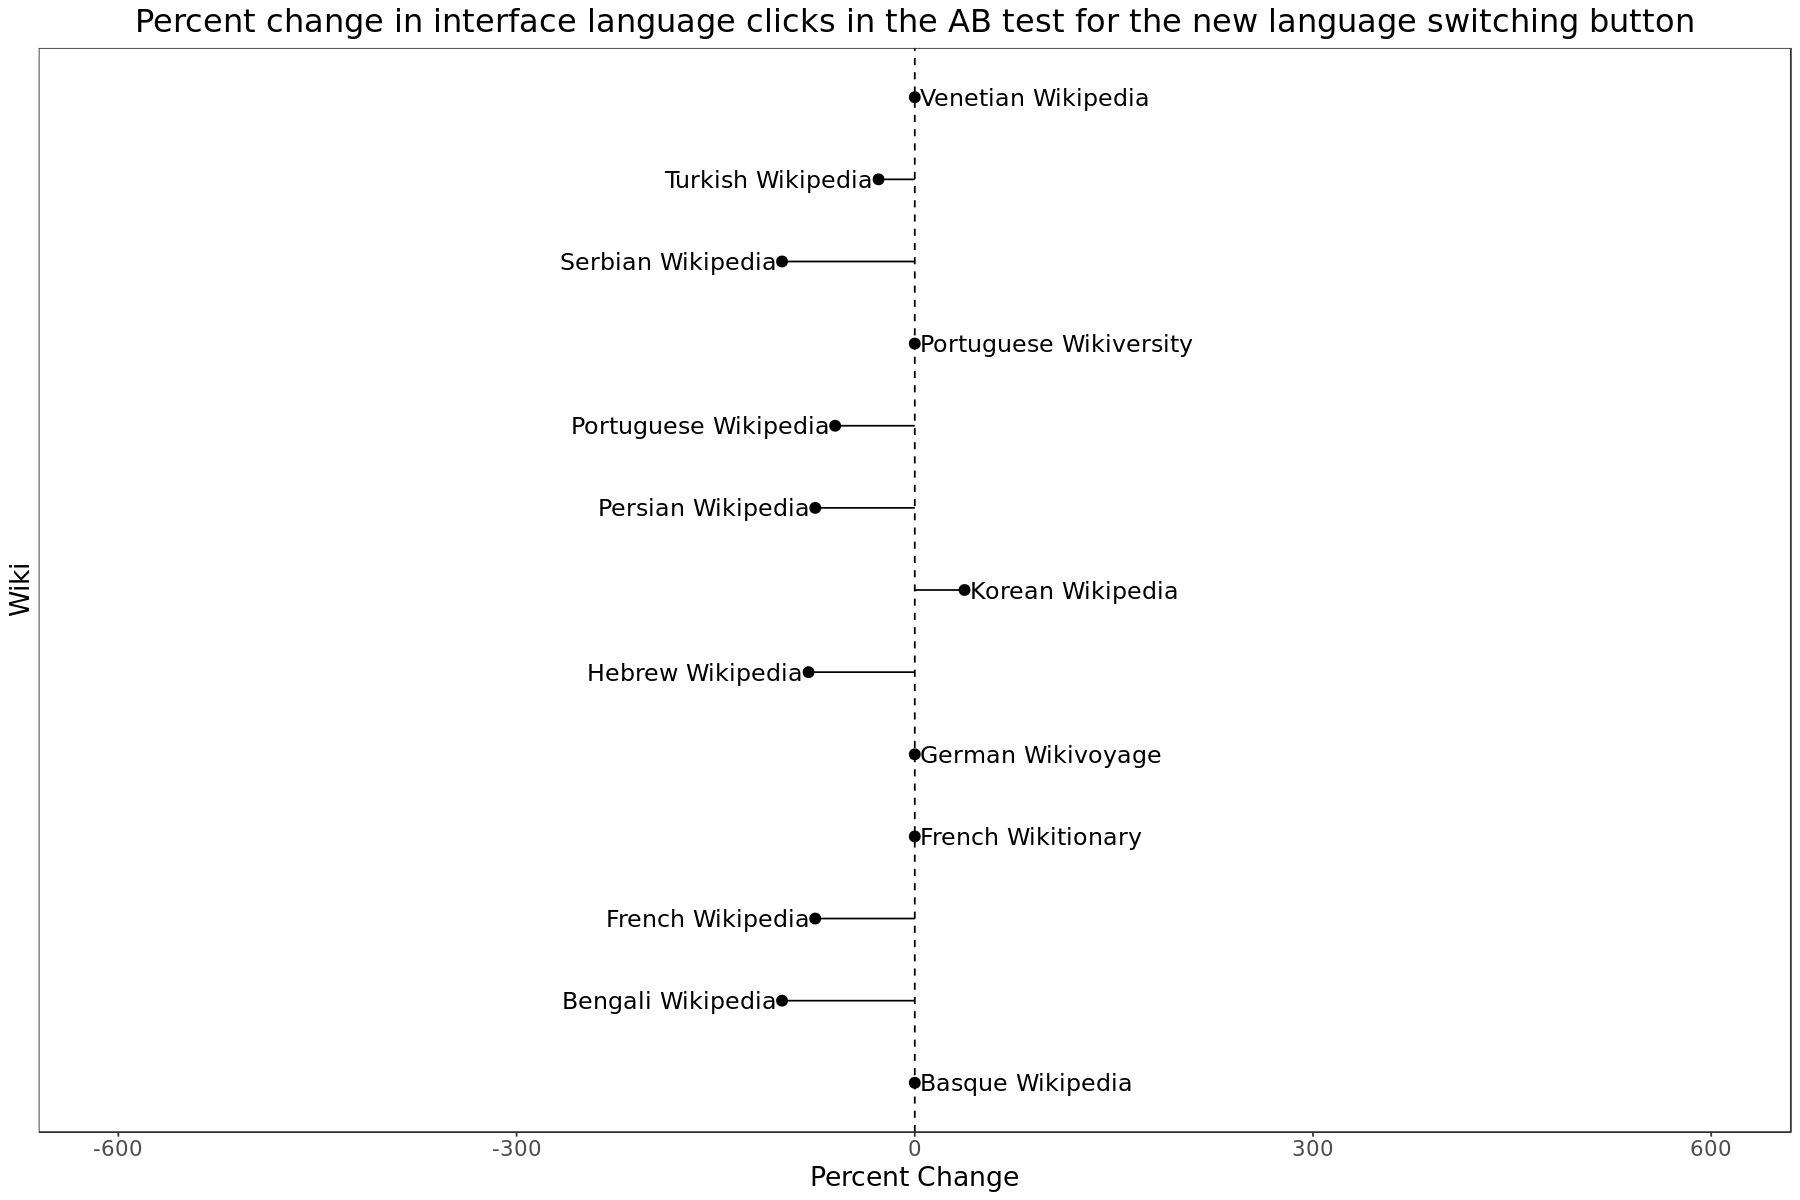

In [137]:

# chart percent change in logged-in user between control and treatment groups for each of the early adopter wikis

pct_interface_g <- df_interface_clicks_AB %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in interface language clicks in the AB test for the new language switching button") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_interface_g 



In [170]:
ggsave("Graphs_login/interface_lang_pct.png",
    plot = pct_interface_g , width = 60, height = 30, units = "cm", dpi = "screen");

__Average percent change__

In [138]:
mean(df_interface_clicks_AB$pct_change, na.rm=TRUE)

[1] -36.90538

__Summary:__

There was an average 36.9% decrease[^3] in total clicks on interface language links by logged-in users on the early adopter wikis in treatment group (with deployment of the new language feature). The average is driven downwards mainly by wikis with low activities.

The activities of interface language switch is low cross wikis, too less to statistically model the impact.

[^3]: Calculated by taking the average of the percent changes observed on each early adopter wiki.

# Other Interesting Trends

__How frequently do users open the list but not switch to a language?__

In [99]:
# number of clicks on new button 
query_new_button <- "
SELECT
    TO_DATE(dt) as button_date,
    wiki as wiki,
    count(1) AS new_button_clicks
FROM event_sanitized.universallanguageselector
WHERE
    year = 2021 and month in (6,7) 
    AND (CONCAT(year,LPAD(month,2,'0'),LPAD(day,2,'0')) between '20210622' and '20210720')
    AND wiki in ('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')
--  useragent is sanitized 
--  AND useragent.is_bot = false
-- only logged in users
    AND event.isanon = false
    AND event.action = 'compact-language-links-open'
    AND event.context = 'header'
    AND event.skinVersion = 'latest'
GROUP BY 
    TO_DATE(dt),
    wiki
"

In [120]:
#df_query_new_button_events <-  wmfdata::query_hive(query_new_button)

In [102]:
date_seq <- seq(as.Date('2021-06-22'), as.Date('2021-07-20'), by = 'days')

wiki_seq <- c('frwiktionary', 'hewiki', 'ptwikiversity', 'frwiki', 
    'euwiki', 'fawiki', 'ptwiki', 'kowiki', 'trwiki', 'srwiki', 'bnwiki', 'dewikivoyage', 'vecwiki')

df= expand.grid(date=date_seq, wiki=wiki_seq )



In [104]:
df<-  merge(df , df_lang_clicks, by.x=c("wiki", "date"),by.y=c("wiki","date"), all.x = TRUE )
df<-  merge(df , df_query_new_button_events, by.x=c("wiki", "date"), by.y=c("wiki","button_date"), all.x = TRUE)
df <-  merge(df , new_input_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"), all.x = TRUE)
df <-  merge(df , new_interface_lang_clicks_by_date, by.x=c("wiki", "date"), by.y=c("wiki","switch_date"),  all.x = TRUE)

In [106]:
df[is.na(df)] <- 0

In [107]:
df <- mutate(df, total_new_switch=n_events_new_language_change+new_input_language_clicks+new_interface_language_clicks)

In [109]:
df <- mutate(df, not_switch_percent=round((new_button_clicks-total_new_switch)*100/new_button_clicks,2))

In [112]:
df <- mutate(df, non_switch_clicks=new_button_clicks-total_new_switch)

In [154]:
write_csv(df, file = 'Data_login/non-switch.csv')

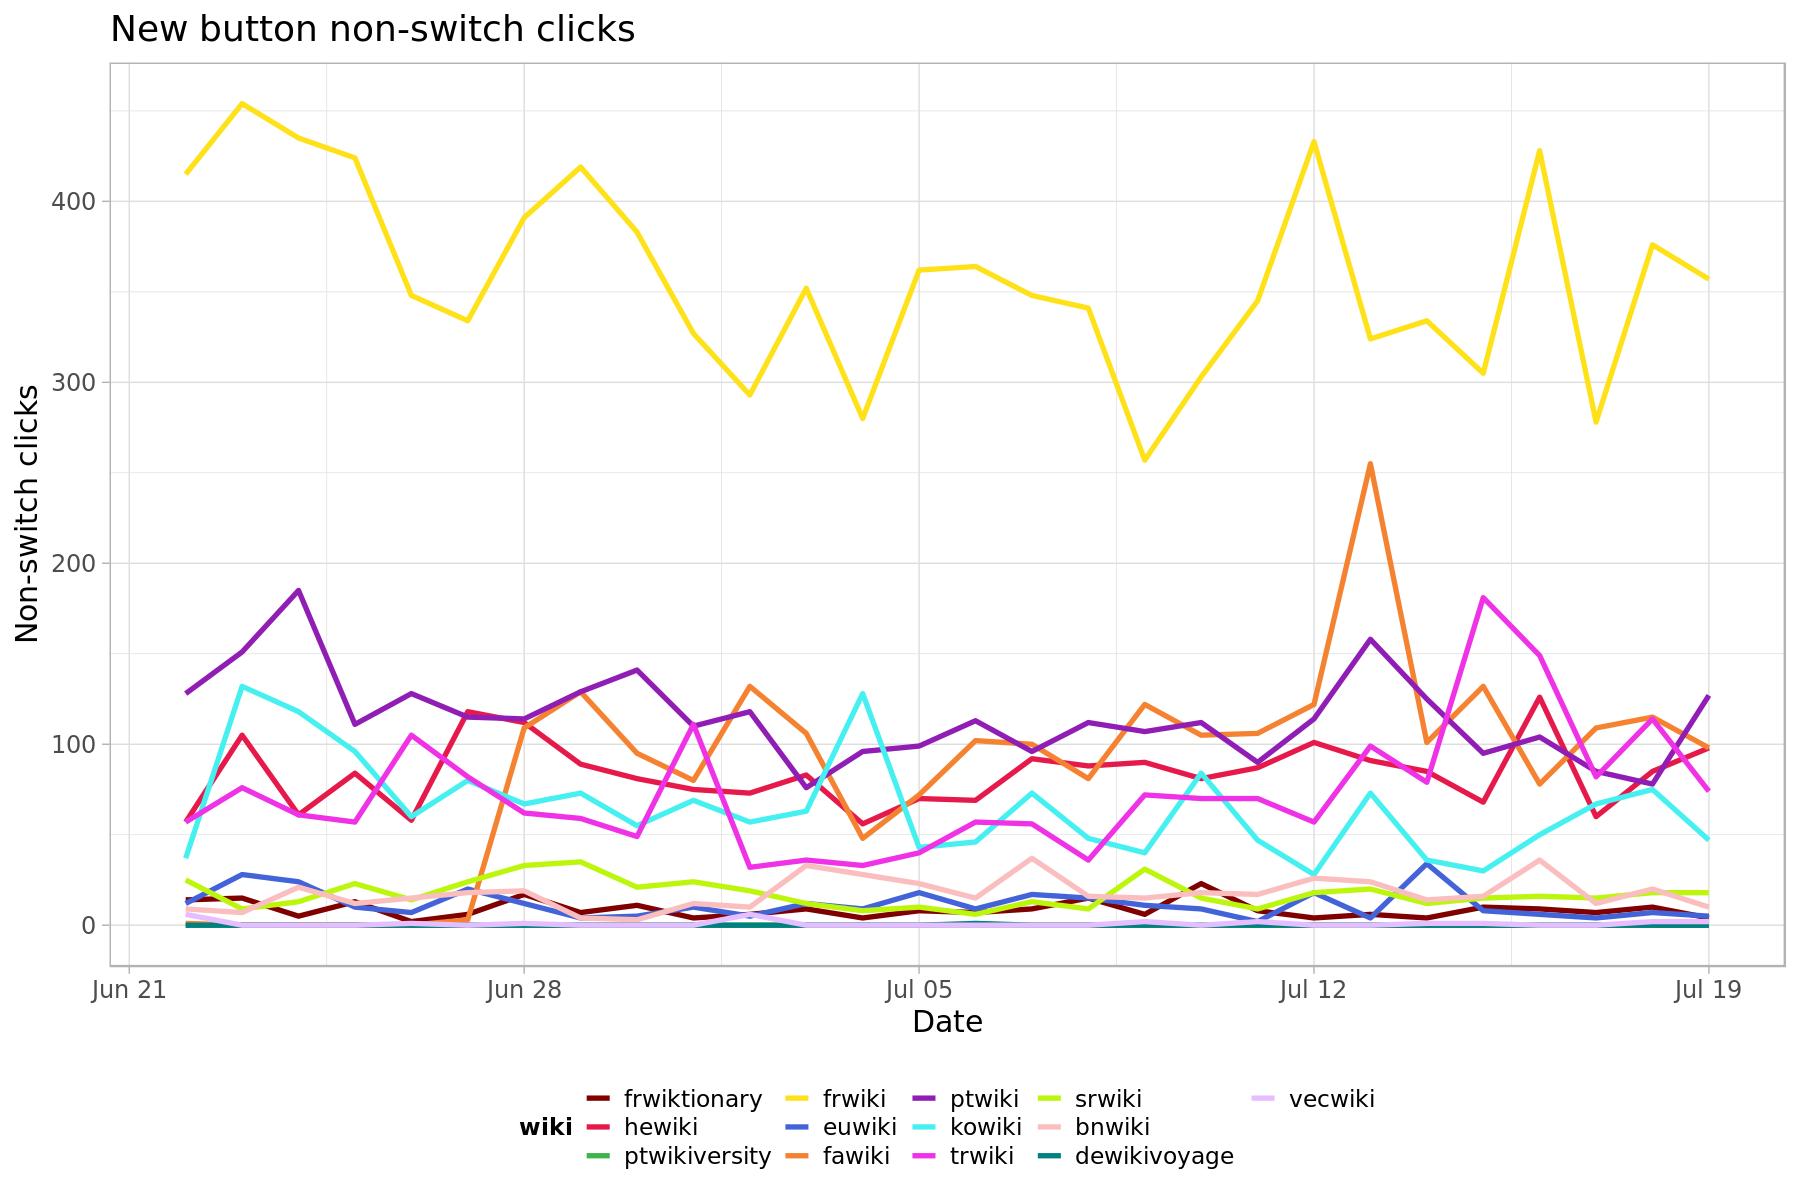

In [114]:
df_graph <- ggplot(data=filter(df, date<'2021-07-20'),
                                mapping=aes(x=date, y=non_switch_clicks, color=wiki)) +
geom_line(size = 1.5) +
labs(title = 'New button non-switch clicks',
     x = 'Date',
     y = 'Non-switch clicks') + 
scale_color_manual(values=c('#800000',  '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
                            '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
                             '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080')) +
theme_light(base_size = 18)+
theme(legend.position = "bottom"
      , legend.text = element_text(size = 14), legend.title = element_text(size = 14, face="bold") );
df_graph

In [171]:
ggsave("Graphs_login/non_switch_clicks.png",
    plot = df_graph , width = 60, height = 30, units = "cm", dpi = "screen");

In [141]:
df_nonswitch_sum <- df %>%
    group_by( wiki_name) %>%
    summarize(button_clicks = sum(new_button_clicks), non_switch_clicks=sum(non_switch_clicks), .groups = 'drop')


In [142]:
df_nonswitch_sum <-  df_nonswitch_sum %>%
  mutate(
        non_switch_rate = case_when(
                            button_clicks==0 ~ 0,
                            TRUE ~ round(non_switch_clicks*100/button_clicks , 2)
                          )
        )

In [143]:
df_nonswitch_sum

wiki_name,button_clicks,non_switch_clicks,non_switch_rate
<chr>,<dbl>,<dbl>,<dbl>
Basque Wikipedia,1701,344,20.22
Bengali Wikipedia,1261,542,42.98
French Wikipedia,36984,10719,28.98
French Wikitionary,960,249,25.94
German Wikivoyage,8,1,12.50
Hebrew Wikipedia,8313,2570,30.92
Korean Wikipedia,5371,1923,35.80
Persian Wikipedia,6574,2521,38.35
Portuguese Wikipedia,11606,3451,29.73


In [118]:
df_nonswitch_sum_long <- pivot_longer(df_nonswitch_sum, cols = c('button_clicks','non_switch_clicks' ), names_to="category", values_to="clicks")

In [129]:

nonswitch_clicks_barchart <- df_nonswitch_sum_long %>%
        ggplot(aes(x = category, y= clicks, fill=category)) +
        geom_bar(stat="identity", position = 'stack') +    
        geom_text(aes(label = paste(clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of button clicks",
             title = "Number of non-switch button clicks") +
     scale_fill_manual(values= c("non_switch_clicks"="#000099", "button_clicks"="#666666"), name = "")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

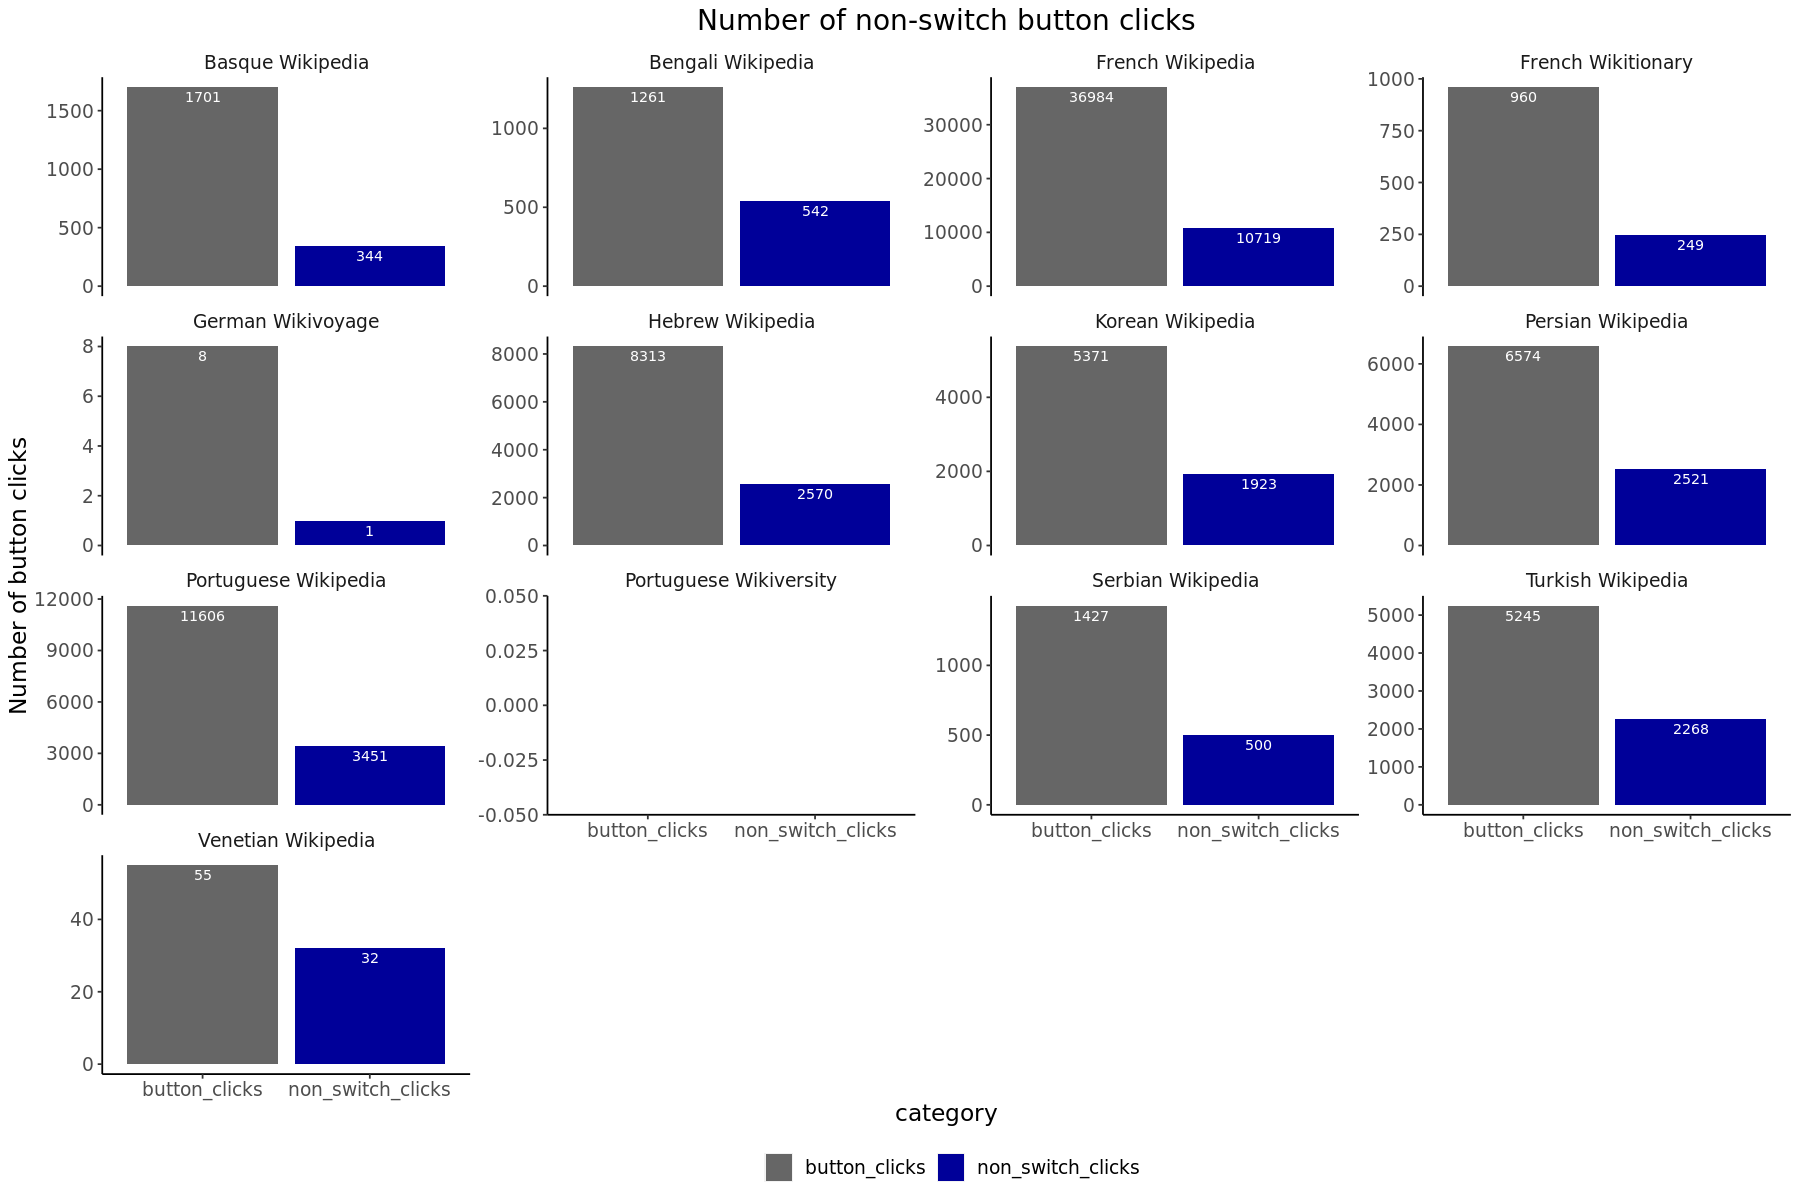

In [130]:
nonswitch_clicks_barchart

In [172]:
ggsave("Graphs_login/non_switch_bar.png",
    plot = nonswitch_clicks_barchart , width = 60, height = 30, units = "cm", dpi = "screen");

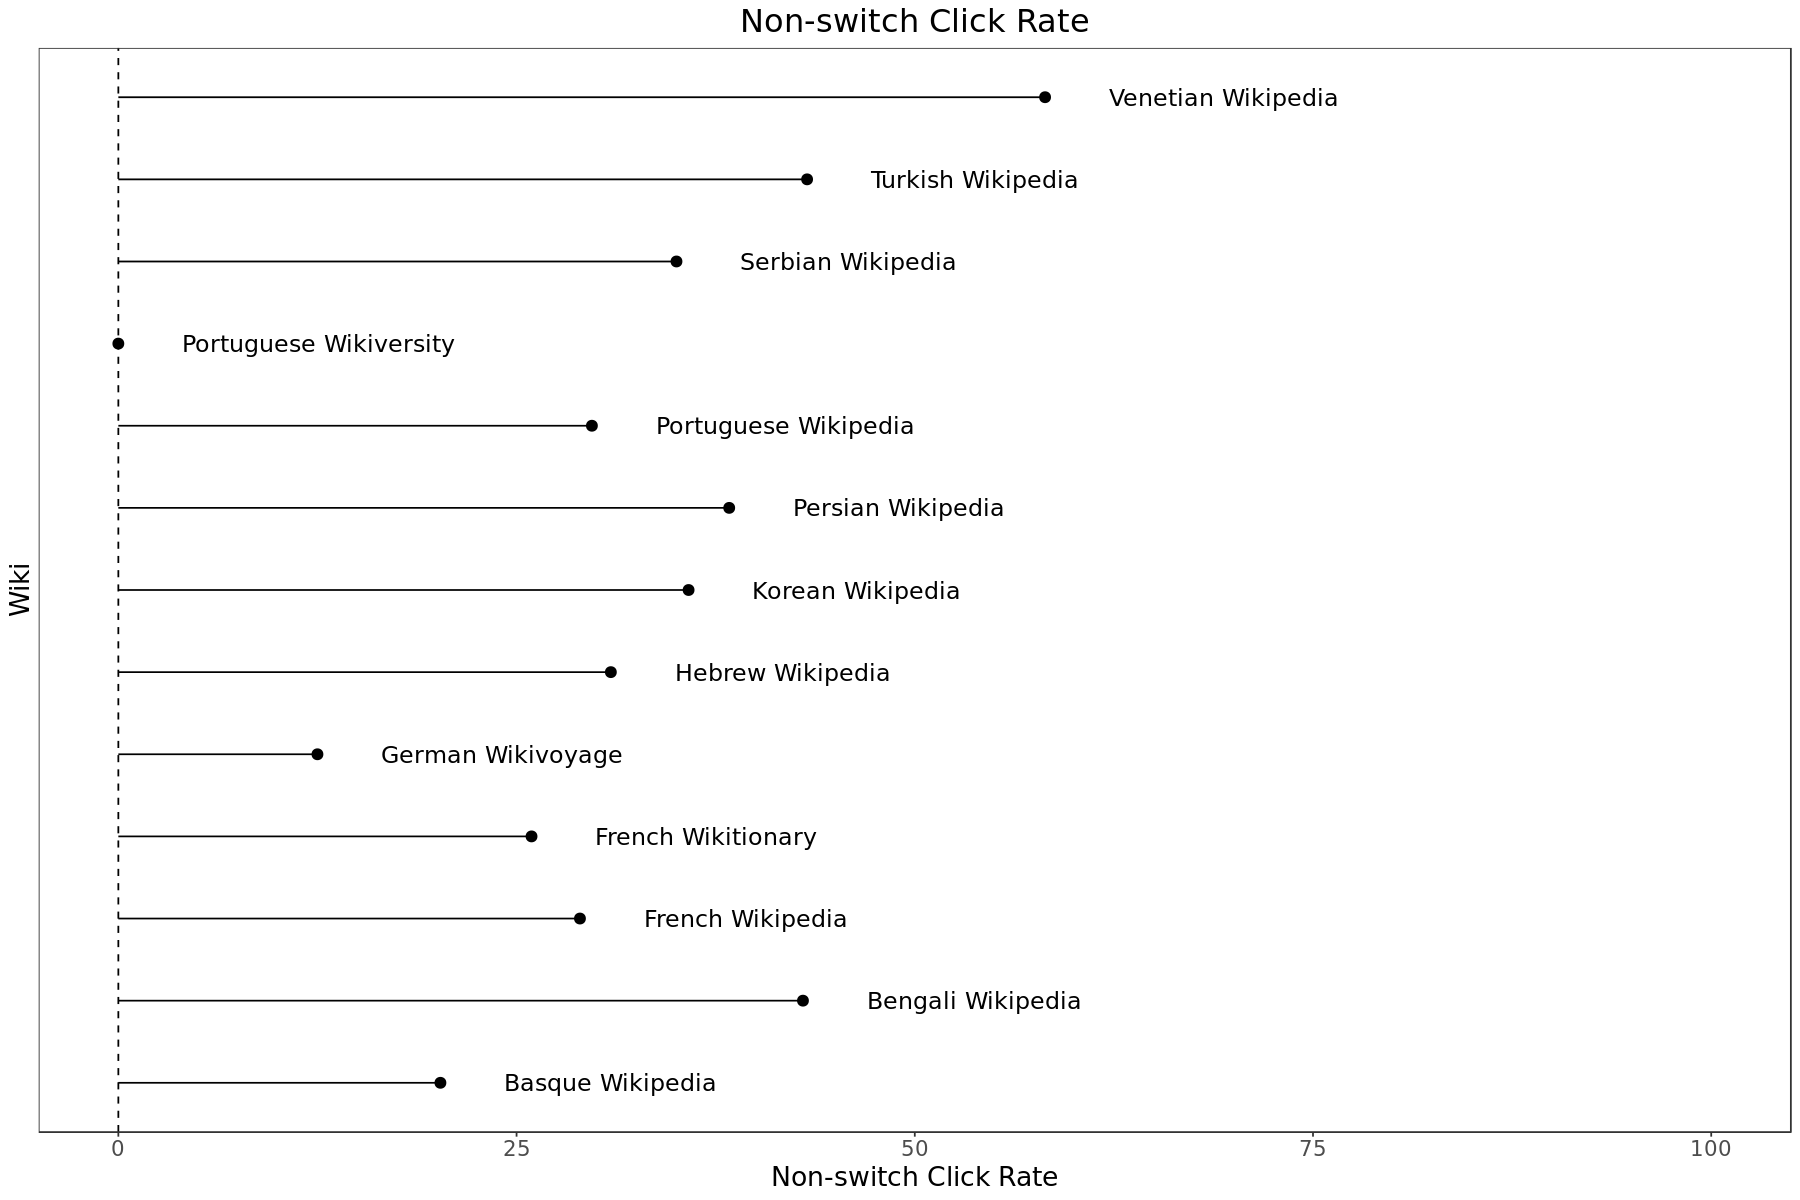

In [151]:
# How frequently do users click the new button but not switch to a language

pct_nonswitch_g <- df_nonswitch_sum %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = non_switch_rate, y = non_switch_rate)
        ) +
        geom_text(
            aes(
                y = non_switch_rate + ifelse(non_switch_rate < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(non_switch_rate < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(0, 100)) +
         labs (x = "Wiki",
                y = "Non-switch Click Rate",
             title = "Non-switch Click Rate") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_nonswitch_g 


In [173]:
ggsave("Graphs_login/non_switch_pct.png",
    plot = pct_nonswitch_g  , width = 60, height = 30, units = "cm", dpi = "screen");

__Average non-switch rate__

In [146]:
mean(df_nonswitch_sum$non_switch_rate, na.rm=TRUE)

[1] 30.91385

__Average non-switch rate excluding low activity wikis__

In [152]:
mean(filter(df_nonswitch_sum, wiki_name!='German Wikivoyage'& wiki_name!='Portuguese Wikiversity' )$non_switch_rate, na.rm=TRUE) 

[1] 35.39818

 __Summary:__   
 
In average[^4], 30.9% of new button clicks do not lead to the next step: switch to a language. If exclude two low activity wikis, German Wikivoyage and Portuguese Wikiversity, the average non-switch rate is 35.4%.  


[^4]: Calculated by taking the average of the percent changes observed on each early adopter wiki.
